## Goal: To test run differnet indicators / method:

### Class to receive buy/sell signals and calculate corresponding ROI:

/var/folders/y0/6wbbf3js39v9tyk2shnjz4j80000gn/T/ipykernel_57754/2546236030.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)


Performance Metrics:
Total Return: 1.06
Annualized Return: 0.72
Volatility: 10.52
Sharpe Ratio: 0.07
Max Drawdown: -11.47
Win Rate: 25.00
Profit Factor: 0.04
Number of Trades: 4.00


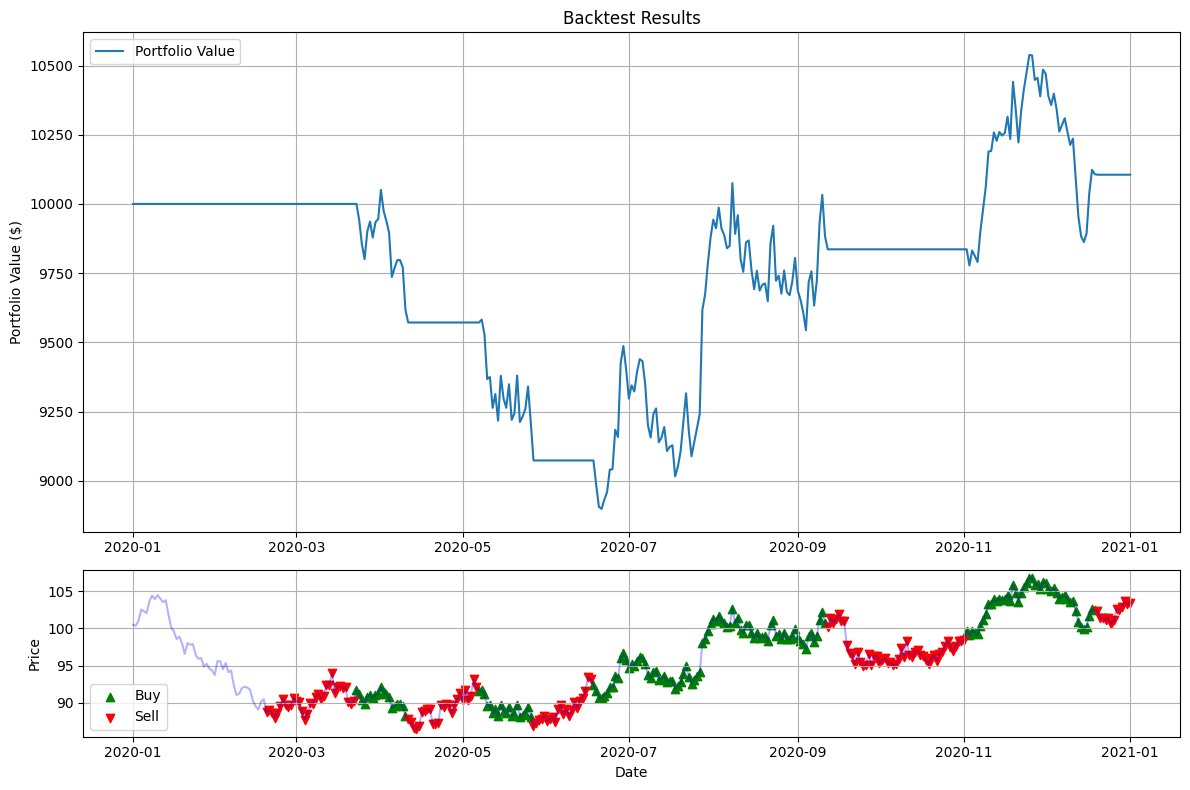


Function-based approach result:
Total Return: -100.00%


In [1]:
# Create a simple example of a backtesting framework for quant trading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Sample implementation of a backtesting framework
class BacktestFramework:
    """
    A class-based framework for backtesting trading strategies.
    """
    def __init__(self, data, initial_capital=10000.0):
        """
        Initialize the backtesting framework.
        
        Parameters:
        -----------
        data : pandas.DataFrame
            Historical price data with at least 'date' and 'close' columns
        initial_capital : float
            Starting capital for the backtest
        """
        self.data = data
        self.initial_capital = initial_capital
        self.positions = pd.DataFrame(index=data.index).fillna(0.0)
        self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
        self.trades = []
        
    def generate_signals(self, strategy_func):
        """
        Generate trading signals based on the provided strategy function.
        
        Parameters:
        -----------
        strategy_func : function
            A function that takes price data and returns signals (1 for buy, -1 for sell, 0 for hold)
        """
        self.signals = strategy_func(self.data)
        return self.signals
    
    def execute_backtest(self):
        """
        Execute the backtest based on the generated signals.
        """
        # Initialize portfolio and holdings
        portfolio = self.initial_capital
        holdings = 0
        
        # Track portfolio value over time
        self.portfolio_value.iloc[0] = portfolio
        
        # Iterate through data points
        for i in range(1, len(self.data)):
            # Get current price and signal
            current_price = self.data['close'].iloc[i]
            current_signal = self.signals.iloc[i]
            prev_signal = self.signals.iloc[i-1]
            
            # Check for trade
            if current_signal == 1 and prev_signal != 1:  # Buy signal
                # Calculate position size (simplified: invest all available capital)
                position_size = portfolio / current_price
                holdings += position_size
                cost = position_size * current_price
                portfolio -= cost
                
                # Record trade
                self.trades.append({
                    'date': self.data.index[i],
                    'type': 'buy',
                    'price': current_price,
                    'quantity': position_size,
                    'cost': cost
                })
                
            elif current_signal == -1 and prev_signal != -1:  # Sell signal
                # Sell all holdings
                revenue = holdings * current_price
                portfolio += revenue
                
                # Record trade
                self.trades.append({
                    'date': self.data.index[i],
                    'type': 'sell',
                    'price': current_price,
                    'quantity': holdings,
                    'revenue': revenue
                })
                
                holdings = 0
            
            # Update portfolio value
            self.portfolio_value.iloc[i] = portfolio + (holdings * current_price)
            # Update positions
            self.positions.iloc[i] = holdings
    
    def calculate_metrics(self):
        """
        Calculate performance metrics for the backtest.
        """
        # Extract portfolio values
        portfolio_values = self.portfolio_value.iloc[:, 0]
        
        # Calculate daily returns
        daily_returns = portfolio_values.pct_change().dropna()
        
        # Calculate metrics
        total_return = (portfolio_values.iloc[-1] / self.initial_capital) - 1
        
        # Annualized return (assuming 252 trading days)
        n_days = len(portfolio_values)
        annualized_return = (1 + total_return) ** (252 / n_days) - 1
        
        # Volatility (annualized)
        volatility = daily_returns.std() * np.sqrt(252)
        
        # Sharpe ratio (assuming risk-free rate of 0 for simplicity)
        sharpe_ratio = annualized_return / volatility if volatility != 0 else 0
        
        # Maximum drawdown
        cumulative_returns = (1 + daily_returns).cumprod()
        running_max = cumulative_returns.cummax()
        drawdowns = (cumulative_returns / running_max) - 1
        max_drawdown = drawdowns.min()
        
        # Win rate
        if len(self.trades) > 0:
            buy_trades = [t for t in self.trades if t['type'] == 'buy']
            sell_trades = [t for t in self.trades if t['type'] == 'sell']
            
            # Pair trades to calculate profit/loss
            profits = []
            for i in range(min(len(buy_trades), len(sell_trades))):
                buy_price = buy_trades[i]['price']
                sell_price = sell_trades[i]['price']
                profit = (sell_price - buy_price) / buy_price
                profits.append(profit)
            
            win_rate = sum(1 for p in profits if p > 0) / len(profits) if profits else 0
            
            # Profit factor
            gross_profits = sum(p for p in profits if p > 0) if profits else 0
            gross_losses = abs(sum(p for p in profits if p < 0)) if profits else 0
            profit_factor = gross_profits / gross_losses if gross_losses != 0 else float('inf')
        else:
            win_rate = 0
            profit_factor = 0
        
        return {
            'Total Return': total_return * 100,
            'Annualized Return': annualized_return * 100,
            'Volatility': volatility * 100,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown': max_drawdown * 100,
            'Win Rate': win_rate * 100,
            'Profit Factor': profit_factor,
            'Number of Trades': len(self.trades) // 2  # Divide by 2 since each round trip is 2 trades
        }
    
    def plot_results(self):
        """
        Plot the backtest results.
        """
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]})
        
        # Plot portfolio value
        ax1.plot(self.portfolio_value.index, self.portfolio_value.values, label='Portfolio Value')
        ax1.set_title('Backtest Results')
        ax1.set_ylabel('Portfolio Value ($)')
        ax1.legend()
        ax1.grid(True)
        
        # Plot buy/sell signals
        buy_signals = self.signals == 1
        sell_signals = self.signals == -1
        
        ax2.plot(self.data.index, self.data['close'], color='blue', alpha=0.3)
        ax2.scatter(self.data.index[buy_signals], self.data.loc[buy_signals, 'close'], 
                   color='green', marker='^', label='Buy')
        ax2.scatter(self.data.index[sell_signals], self.data.loc[sell_signals, 'close'], 
                   color='red', marker='v', label='Sell')
        ax2.set_ylabel('Price')
        ax2.set_xlabel('Date')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()


# Example usage with a simple moving average crossover strategy
def moving_average_crossover(data, short_window=20, long_window=50):
    """
    A simple moving average crossover strategy.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Historical price data with at least 'close' column
    short_window : int
        Short moving average window
    long_window : int
        Long moving average window
    
    Returns:
    --------
    pandas.Series
        Series of signals (1 for buy, -1 for sell, 0 for hold)
    """
    signals = pd.Series(index=data.index, data=0)
    
    # Create moving averages
    data['short_ma'] = data['close'].rolling(window=short_window).mean()
    data['long_ma'] = data['close'].rolling(window=long_window).mean()
    
    # Generate signals
    signals[data['short_ma'] > data['long_ma']] = 1  # Buy signal
    signals[data['short_ma'] < data['long_ma']] = -1  # Sell signal
    
    return signals

# Create sample data
dates = pd.date_range(start='2020-01-01', end='2021-01-01', freq='D')
np.random.seed(42)  # For reproducibility
prices = 100 + np.cumsum(np.random.normal(0, 1, len(dates)))
sample_data = pd.DataFrame({
    'close': prices,
    'open': prices * 0.99,
    'high': prices * 1.01,
    'low': prices * 0.98,
    'volume': np.random.randint(1000, 10000, len(dates))
}, index=dates)

# Create and run backtest
backtest = BacktestFramework(sample_data)
backtest.generate_signals(moving_average_crossover)
backtest.execute_backtest()
metrics = backtest.calculate_metrics()

# Print metrics
print("Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

# Plot results
backtest.plot_results()

# ================================================================================================

# Example of a function-based approach for comparison
def backtest_strategy(data, strategy_func, initial_capital=10000.0):
    """
    A function-based approach to backtesting.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Historical price data
    strategy_func : function
        Trading strategy function that returns signals
    initial_capital : float
        Initial capital for the backtest
    
    Returns:
    --------
    dict
        Performance metrics
    """
    # Generate signals
    signals = strategy_func(data)
    
    # Initialize portfolio tracking
    portfolio = pd.Series(index=data.index, data=initial_capital)
    positions = pd.Series(index=data.index, data=0.0)
    
    # Execute backtest
    for i in range(1, len(data)):
        if signals.iloc[i] == 1 and signals.iloc[i-1] != 1:
            # Buy
            positions.iloc[i] = portfolio.iloc[i-1] / data['close'].iloc[i]
            portfolio.iloc[i] = 0
        elif signals.iloc[i] == -1 and signals.iloc[i-1] != -1:
            # Sell
            portfolio.iloc[i] = positions.iloc[i-1] * data['close'].iloc[i]
            positions.iloc[i] = 0
        else:
            # Hold
            positions.iloc[i] = positions.iloc[i-1]
            portfolio.iloc[i] = portfolio.iloc[i-1]
    
    # Calculate final portfolio value
    final_portfolio = portfolio + positions * data['close']
    
    # Calculate metrics (simplified)
    total_return = (final_portfolio.iloc[-1] / initial_capital) - 1
    
    return {
        'Total Return': total_return * 100
    }

# Compare with function-based approach
func_result = backtest_strategy(sample_data, moving_average_crossover)
print("\nFunction-based approach result:")
print(f"Total Return: {func_result['Total Return']:.2f}%")


### Handsome Guy

In [ ]:
import pandas as pd

## For Windows:
df_BTC = pd.read_csv('crypto_data\\BTCUSDT_1h.csv')
df_BTC = df_BTC.dropna()
df_BTC.head()

In [5]:
import pandas as pd

## For MacOS:
df_BTC = pd.read_csv('crypto_data/BTCUSDT_1h.csv')
df_BTC = df_BTC.dropna()
df_BTC.head()

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_volume,taker_buy_quote_volume
0,2020-03-10 15:00:00,8040.85,8040.99,7739.97,7767.28,10207.987992,8.052126e+07,73657,4806.225421,3.794594e+07
1,2020-03-10 16:00:00,7766.29,7860.00,7728.01,7843.55,5524.890041,4.320173e+07,45553,2761.328181,2.158740e+07
2,2020-03-10 17:00:00,7843.06,7910.19,7821.58,7869.90,4208.895185,3.310968e+07,29975,2179.673464,1.715007e+07
3,2020-03-10 18:00:00,7869.88,7893.15,7801.00,7865.51,3212.115482,2.521028e+07,30878,1706.184792,1.339211e+07
4,2020-03-10 19:00:00,7865.65,7985.00,7847.45,7978.80,3366.463372,2.666008e+07,28019,2072.792577,1.642075e+07


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Technical indicator calculation functions
def calculate_rsi(prices, period=14):
    """Calculate Relative Strength Index (RSI)"""
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

def calculate_macd(prices, fast_period=12, slow_period=26, signal_period=9):
    """Calculate Moving Average Convergence Divergence (MACD)"""
    ema_fast = prices.ewm(span=fast_period, adjust=False).mean()
    ema_slow = prices.ewm(span=slow_period, adjust=False).mean()
    
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    histogram = macd_line - signal_line
    
    return macd_line, signal_line, histogram

def calculate_bollinger_bands(prices, window=20, num_std=2):
    """Calculate Bollinger Bands"""
    middle_band = prices.rolling(window=window).mean()
    std_dev = prices.rolling(window=window).std()
    upper_band = middle_band + (std_dev * num_std)
    lower_band = middle_band - (std_dev * num_std)
    bb_width = (upper_band - lower_band) / middle_band
    
    return middle_band, upper_band, lower_band, bb_width

# Enhanced Backtesting Framework
class EnhancedBacktestFramework:
    """
    An enhanced class-based framework for backtesting trading strategies.
    """
    def __init__(self, data, initial_capital=10000.0, position_size=0.95, stop_loss_pct=0.05):
        """
        Initialize the backtesting framework.
        
        Parameters:
        -----------
        data : pandas.DataFrame
            Historical price data with OHLCV columns
        initial_capital : float
            Starting capital for the backtest
        position_size : float
            Percentage of capital to use per trade (0-1)
        stop_loss_pct : float
            Stop loss percentage (0-1)
        """
        self.data = data.copy()
        self.initial_capital = initial_capital
        self.position_size = position_size
        self.stop_loss_pct = stop_loss_pct
        
        # Initialize tracking dataframes
        self.positions = pd.DataFrame(index=data.index).fillna(0.0)
        self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
        self.portfolio_value.iloc[0] = initial_capital
        self.trades = []
        
        # Add technical indicators to data
        self._add_indicators()
        
    def _add_indicators(self):
        """Add technical indicators to the data"""
        # RSI
        self.data['rsi'] = calculate_rsi(self.data['close'])
        
        # MACD
        self.data['macd'], self.data['signal'], self.data['histogram'] = calculate_macd(self.data['close'])
        
        # Bollinger Bands
        self.data['middle_band'], self.data['upper_band'], self.data['lower_band'], self.data['bb_width'] = calculate_bollinger_bands(self.data['close'])
        
        # Volatility indicators
        self.data['bb_width_ma'] = self.data['bb_width'].rolling(50).mean()
        self.data['high_volatility'] = self.data['bb_width'] > self.data['bb_width_ma'] * 1.2
        self.data['low_volatility'] = self.data['bb_width'] < self.data['bb_width_ma'] * 0.8
        
        # Market regime detection (simple method based on moving averages)
        self.data['sma50'] = self.data['close'].rolling(50).mean()
        self.data['sma200'] = self.data['close'].rolling(200).mean()
        
        # Define regimes: bull, bear, sideways
        self.data['regime'] = 'sideways'
        self.data.loc[self.data['sma50'] > self.data['sma200'] * 1.05, 'regime'] = 'bull'
        self.data.loc[self.data['sma50'] < self.data['sma200'] * 0.95, 'regime'] = 'bear'
        
    def generate_signals_strategy1(self):
        """
        Strategy 1: RSI + MACD
        - Buy when RSI < 30 and MACD > Signal
        - Sell when RSI > 70 or MACD < Signal
        """
        signals = pd.Series(index=self.data.index, data=0)
        
        # Generate buy signals
        buy_condition = (self.data['rsi'] < 30) & (self.data['macd'] > self.data['signal'])
        signals[buy_condition] = 1
        
        # Generate sell signals
        sell_condition = (self.data['rsi'] > 70) | (self.data['macd'] < self.data['signal'])
        signals[sell_condition] = -1
        
        self.signals = signals
        return signals
    
    def generate_signals_strategy2(self):
        """
        Strategy 2: Bollinger Bands + RSI (Best performer in our test)
        - Buy when price < Lower Band and RSI < 40
        - Sell when price > Upper Band or RSI > 60
        """
        signals = pd.Series(index=self.data.index, data=0)
        
        # Generate buy signals
        buy_condition = (self.data['close'] < self.data['lower_band']) & (self.data['rsi'] < 40)
        signals[buy_condition] = 1
        
        # Generate sell signals
        sell_condition = (self.data['close'] > self.data['upper_band']) | (self.data['rsi'] > 60)
        signals[sell_condition] = -1
        
        self.signals = signals
        return signals
    
    def generate_signals_strategy3(self):
        """
        Strategy 3: Triple Confirmation
        - Buy when price < Lower Band and RSI < 40 and MACD > Signal
        - Sell when price > Upper Band or RSI > 60 or MACD < Signal
        """
        signals = pd.Series(index=self.data.index, data=0)
        
        # Generate buy signals
        buy_condition = (self.data['close'] < self.data['lower_band']) & (self.data['rsi'] < 40) & (self.data['macd'] > self.data['signal'])
        signals[buy_condition] = 1
        
        # Generate sell signals
        sell_condition = (self.data['close'] > self.data['upper_band']) | (self.data['rsi'] > 60) | (self.data['macd'] < self.data['signal'])
        signals[sell_condition] = -1
        
        self.signals = signals
        return signals
    
    def generate_signals_strategy4(self):
        """
        Strategy 4: Adaptive Strategy based on volatility
        - High volatility: Use BB mean reversion (price < Lower Band and RSI < 40)
        - Low volatility: Use MACD for trend following (MACD crosses above Signal)
        """
        signals = pd.Series(index=self.data.index, data=0)
        
        # High volatility buy condition (mean reversion)
        high_vol_buy = (self.data['high_volatility']) & (self.data['close'] < self.data['lower_band']) & (self.data['rsi'] < 40)
        
        # Low volatility buy condition (trend following)
        low_vol_buy = (self.data['low_volatility']) & (self.data['macd'] > self.data['signal']) & (self.data['macd'].shift(1) <= self.data['signal'].shift(1))
        
        # Combined buy signals
        buy_condition = high_vol_buy | low_vol_buy
        signals[buy_condition] = 1
        
        # High volatility sell condition
        high_vol_sell = (self.data['high_volatility']) & (self.data['close'] > self.data['upper_band']) & (self.data['rsi'] > 60)
        
        # Low volatility sell condition
        low_vol_sell = (self.data['low_volatility']) & (self.data['macd'] < self.data['signal']) & (self.data['macd'].shift(1) >= self.data['signal'].shift(1))
        
        # Combined sell signals
        sell_condition = high_vol_sell | low_vol_sell
        signals[sell_condition] = -1
        
        self.signals = signals
        return signals
    
    def execute_backtest(self):
        """
        Execute the backtest based on the generated signals with proper risk management.
        """
        # Initialize portfolio and holdings
        portfolio = self.initial_capital
        holdings = 0
        entry_price = 0
        stop_loss_price = 0
        
        # Track portfolio value over time
        self.portfolio_value.iloc[0] = portfolio
        
        # Iterate through data points
        for i in range(1, len(self.data)):
            # Get current price data and signal
            current_price = self.data['close'].iloc[i]
            current_low = self.data['low'].iloc[i]
            current_signal = self.signals.iloc[i]
            prev_signal = self.signals.iloc[i-1]
            
            # Check for stop loss if in position
            if holdings > 0 and current_low <= stop_loss_price:
                # Stop loss hit - exit at stop loss price
                revenue = holdings * stop_loss_price
                portfolio += revenue
                
                # Record trade
                self.trades.append({
                    'date': self.data.index[i],
                    'type': 'sell',
                    'reason': 'stop_loss',
                    'price': stop_loss_price,
                    'quantity': holdings,
                    'revenue': revenue,
                    'profit': revenue - (holdings * entry_price),
                    'return': (stop_loss_price - entry_price) / entry_price
                })
                
                holdings = 0
                entry_price = 0
                stop_loss_price = 0
                
            # Check for buy signal if not in position
            elif holdings == 0 and current_signal == 1 and prev_signal != 1:
                # Calculate position size based on risk management
                entry_price = current_price
                stop_loss_price = entry_price * (1 - self.stop_loss_pct)
                risk_amount = entry_price - stop_loss_price
                
                # Determine position size
                capital_to_use = portfolio * self.position_size
                holdings = capital_to_use / current_price
                cost = holdings * current_price
                portfolio -= cost
                
                # Record trade
                self.trades.append({
                    'date': self.data.index[i],
                    'type': 'buy',
                    'price': entry_price,
                    'quantity': holdings,
                    'cost': cost,
                    'stop_loss': stop_loss_price
                })
                
            # Check for sell signal if in position
            elif holdings > 0 and current_signal == -1 and prev_signal != -1:
                # Sell based on signal
                revenue = holdings * current_price
                portfolio += revenue
                
                # Record trade
                self.trades.append({
                    'date': self.data.index[i],
                    'type': 'sell',
                    'reason': 'signal',
                    'price': current_price,
                    'quantity': holdings,
                    'revenue': revenue,
                    'profit': revenue - (holdings * entry_price),
                    'return': (current_price - entry_price) / entry_price
                })
                
                holdings = 0
                entry_price = 0
                stop_loss_price = 0
            
            # Update portfolio value
            self.portfolio_value.iloc[i] = portfolio + (holdings * current_price)
            # Update positions
            self.positions.iloc[i] = holdings
    
    def calculate_metrics(self):
        """
        Calculate comprehensive performance metrics for the backtest.
        """
        # Extract portfolio values
        portfolio_values = self.portfolio_value.iloc[:, 0]
        
        # Calculate daily returns
        daily_returns = portfolio_values.pct_change().dropna()
        
        # Calculate metrics
        total_return = (portfolio_values.iloc[-1] / self.initial_capital) - 1
        
        # Annualized return (assuming 252 trading days)
        n_days = len(portfolio_values)
        annualized_return = (1 + total_return) ** (252 / n_days) - 1 if n_days > 0 else 0
        
        # Volatility (annualized)
        volatility = daily_returns.std() * np.sqrt(252) if len(daily_returns) > 0 else 0
        
        # Sharpe ratio (assuming risk-free rate of 0 for simplicity)
        sharpe_ratio = annualized_return / volatility if volatility != 0 else 0
        
        # Maximum drawdown
        if len(daily_returns) > 0:
            cumulative_returns = (1 + daily_returns).cumprod()
            running_max = cumulative_returns.cummax()
            drawdowns = (cumulative_returns / running_max) - 1
            max_drawdown = drawdowns.min()
        else:
            max_drawdown = 0
        
        # Trade metrics
        if len(self.trades) > 0:
            # Filter for completed trades (sells)
            sell_trades = [t for t in self.trades if t['type'] == 'sell']
            
            # Calculate win rate
            wins = sum(1 for t in sell_trades if t.get('return', 0) > 0)
            win_rate = wins / len(sell_trades) if len(sell_trades) > 0 else 0
            
            # Calculate profit factor
            gross_profits = sum(t.get('profit', 0) for t in sell_trades if t.get('profit', 0) > 0)
            gross_losses = abs(sum(t.get('profit', 0) for t in sell_trades if t.get('profit', 0) < 0))
            profit_factor = gross_profits / gross_losses if gross_losses != 0 else float('inf')
            
            # Average trade metrics
            avg_return = sum(t.get('return', 0) for t in sell_trades) / len(sell_trades) if sell_trades else 0
            avg_profit = sum(t.get('profit', 0) for t in sell_trades) / len(sell_trades) if sell_trades else 0
            
            # Exit type analysis
            stop_loss_exits = sum(1 for t in sell_trades if t.get('reason') == 'stop_loss')
            signal_exits = sum(1 for t in sell_trades if t.get('reason') == 'signal')
            
            # Performance by market regime
            regime_returns = {}
            for regime in self.data['regime'].unique():
                regime_data = self.data[self.data['regime'] == regime]
                if len(regime_data) > 0:
                    regime_portfolio_values = portfolio_values.loc[regime_data.index]
                    if len(regime_portfolio_values) > 1:
                        regime_return = (regime_portfolio_values.iloc[-1] / regime_portfolio_values.iloc[0]) - 1
                        regime_returns[regime] = regime_return * 100
        else:
            win_rate = 0
            profit_factor = 0
            avg_return = 0
            avg_profit = 0
            stop_loss_exits = 0
            signal_exits = 0
            regime_returns = {}
        
        return {
            'Total Return (%)': total_return * 100,
            'Annualized Return (%)': annualized_return * 100,
            'Volatility (%)': volatility * 100,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown (%)': max_drawdown * 100,
            'Win Rate (%)': win_rate * 100,
            'Profit Factor': profit_factor,
            'Average Trade Return (%)': avg_return * 100,
            'Average Trade Profit ($)': avg_profit,
            'Number of Trades': len(self.trades) // 2,  # Divide by 2 since each round trip is 2 trades
            'Stop Loss Exits': stop_loss_exits,
            'Signal Exits': signal_exits,
            'Regime Returns': regime_returns
        }
    
    def plot_results(self):
        """
        Plot comprehensive backtest results.
        """
        # Create figure with subplots
        fig = plt.figure(figsize=(15, 12))
        gs = fig.add_gridspec(3, 2)
        
        # Plot 1: Portfolio Value
        ax1 = fig.add_subplot(gs[0, :])
        ax1.plot(self.portfolio_value.index, self.portfolio_value.values, label='Portfolio Value')
        ax1.set_title('Portfolio Value Over Time')
        ax1.set_ylabel('Portfolio Value ($)')
        ax1.legend()
        ax1.grid(True)
        
        # Plot 2: Price with Buy/Sell Signals and Indicators
        ax2 = fig.add_subplot(gs[1, :])
        ax2.plot(self.data.index, self.data['close'], label='Close Price', color='blue', alpha=0.6)
        ax2.plot(self.data.index, self.data['upper_band'], label='Upper BB', color='gray', linestyle='--', alpha=0.4)
        ax2.plot(self.data.index, self.data['middle_band'], label='Middle BB', color='gray', linestyle='-', alpha=0.4)
        ax2.plot(self.data.index, self.data['lower_band'], label='Lower BB', color='gray', linestyle='--', alpha=0.4)
        
        # Add buy/sell markers
        buy_signals = (self.signals == 1) & (self.signals.shift(1) != 1)
        sell_signals = (self.signals == -1) & (self.signals.shift(1) != -1)
        
        ax2.scatter(self.data.index[buy_signals], self.data.loc[buy_signals, 'close'], 
                   color='green', marker='^', s=100, label='Buy Signal')
        ax2.scatter(self.data.index[sell_signals], self.data.loc[sell_signals, 'close'], 
                   color='red', marker='v', s=100, label='Sell Signal')
        
        # Add stop losses if available
        if self.trades:
            stop_loss_exits = [t for t in self.trades if t['type'] == 'sell' and t.get('reason') == 'stop_loss']
            if stop_loss_exits:
                stop_loss_dates = [t['date'] for t in stop_loss_exits]
                stop_loss_prices = [t['price'] for t in stop_loss_exits]
                ax2.scatter(stop_loss_dates, stop_loss_prices, color='purple', marker='x', s=100, label='Stop Loss')
        
        ax2.set_title('Price Chart with Signals')
        ax2.set_ylabel('Price')
        ax2.legend()
        ax2.grid(True)
        
        # Plot 3: RSI
        ax3 = fig.add_subplot(gs[2, 0])
        ax3.plot(self.data.index, self.data['rsi'], label='RSI', color='purple')
        ax3.axhline(y=70, color='r', linestyle='--', alpha=0.3)
        ax3.axhline(y=30, color='g', linestyle='--', alpha=0.3)
        ax3.axhline(y=50, color='k', linestyle='--', alpha=0.2)
        ax3.fill_between(self.data.index, 70, 100, color='r', alpha=0.1)
        ax3.fill_between(self.data.index, 0, 30, color='g', alpha=0.1)
        ax3.set_title('RSI Indicator')
        ax3.set_ylabel('RSI')
        ax3.set_ylim(0, 100)
        ax3.grid(True)
        
        # Plot 4: MACD
        ax4 = fig.add_subplot(gs[2, 1])
        ax4.plot(self.data.index, self.data['macd'], label='MACD', color='blue')
        ax4.plot(self.data.index, self.data['signal'], label='Signal', color='red')
        ax4.bar(self.data.index, self.data['histogram'], label='Histogram', color='gray', alpha=0.4)
        ax4.set_title('MACD Indicator')
        ax4.set_ylabel('MACD')
        ax4.legend()
        ax4.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Additional plot for drawdowns
        plt.figure(figsize=(12, 6))
        portfolio_values = self.portfolio_value.iloc[:, 0]
        daily_returns = portfolio_values.pct_change().dropna()
        
        if len(daily_returns) > 0:
            cumulative_returns = (1 + daily_returns).cumprod()
            running_max = cumulative_returns.cummax()
            drawdowns = (cumulative_returns / running_max) - 1
            
            plt.plot(drawdowns.index, drawdowns * 100)
            plt.fill_between(drawdowns.index, drawdowns * 100, 0, color='red', alpha=0.3)
            plt.title('Portfolio Drawdowns')
            plt.ylabel('Drawdown (%)')
            plt.xlabel('Date')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        
        # Plot trade distribution if there are trades
        if len(self.trades) > 0:
            sell_trades = [t for t in self.trades if t['type'] == 'sell']
            if sell_trades:
                returns = [t.get('return', 0) * 100 for t in sell_trades]
                
                plt.figure(figsize=(10, 6))
                plt.hist(returns, bins=20, alpha=0.7, color='blue')
                plt.axvline(0, color='r', linestyle='--')
                plt.title('Trade Return Distribution')
                plt.xlabel('Trade Return (%)')
                plt.ylabel('Frequency')
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
                
                # Plot returns by market regime
                if 'regime' in self.data.columns:
                    regime_returns = {}
                    for regime in self.data['regime'].unique():
                        regime_trades = [t for t in sell_trades if self.data.loc[t['date'], 'regime'] == regime]
                        if regime_trades:
                            regime_returns[regime] = [t.get('return', 0) * 100 for t in regime_trades]
                    
                    if regime_returns:
                        plt.figure(figsize=(10, 6))
                        for regime, returns in regime_returns.items():
                            plt.hist(returns, bins=10, alpha=0.5, label=regime)
                        plt.axvline(0, color='k', linestyle='--')
                        plt.title('Trade Returns by Market Regime')
                        plt.xlabel('Trade Return (%)')
                        plt.ylabel('Frequency')
                        plt.legend()
                        plt.grid(True, alpha=0.3)
                        plt.tight_layout()
                        plt.show()


# Create sample data with more realistic price movements
def create_sample_data(days=500, seed=42):
    """Create sample data with realistic price movements"""
    np.random.seed(seed)
    dates = pd.date_range(start='2020-01-01', periods=days)
    
    # Create a more realistic price series with trends, cycles, and some randomness
    trend = np.linspace(0, 50, days)  # Upward trend
    cycle1 = 15 * np.sin(np.linspace(0, 8*np.pi, days))  # Longer cycle
    cycle2 = 8 * np.sin(np.linspace(0, 32*np.pi, days))  # Shorter cycle
    noise = np.random.normal(0, 3, days)  # Random noise

    # Add some market regimes - bull, bear, sideways
    regimes = []
    regime_lengths = [100, 150, 100, 150]  # Different regime lengths
    regime_types = ['bull', 'bear', 'sideways', 'bull']  # Different regime types
    regime_factors = [1.5, 0.5, 0.2, 1.2]  # Factors to adjust the trend

    current_idx = 0
    for length, regime, factor in zip(regime_lengths, regime_types, regime_factors):
        regimes.extend([regime] * length)
        if current_idx + length <= days:
            if regime == 'bull':
                trend[current_idx:current_idx+length] *= factor
            elif regime == 'bear':
                trend[current_idx:current_idx+length] *= -factor
            elif regime == 'sideways':
                trend[current_idx:current_idx+length] *= factor
        current_idx += length

    # Ensure regimes list matches days length
    regimes = regimes[:days]

    price = 100 + trend + cycle1 + cycle2 + noise
    
    # Create OHLCV data
    data = pd.DataFrame({
        'open': price * (1 + np.random.normal(0, 0.005, days)),
        'high': price * (1 + abs(np.random.normal(0, 0.01, days))),
        'low': price * (1 - abs(np.random.normal(0, 0.01, days))),
        'close': price,
        'volume': np.random.normal(1000000, 200000, days)
    }, index=dates)
    
    # Ensure high is always highest and low is always lowest
    data['high'] = np.maximum(data[['open', 'close', 'high']].max(axis=1), data['high'])
    data['low'] = np.minimum(data[['open', 'close', 'low']].min(axis=1), data['low'])
    
    return data

# Create sample data
sample_data = create_sample_data(days=500)


# Test each strategy
strategies = [
    ("Strategy 1: RSI + MACD", "generate_signals_strategy1"),
    ("Strategy 2: BB + RSI", "generate_signals_strategy2"),
    ("Strategy 3: Triple Confirmation", "generate_signals_strategy3"),
    ("Strategy 4: Adaptive Strategy", "generate_signals_strategy4")
]

results = {}

for strategy_name, strategy_method in strategies:
    print(f"\nTesting {strategy_name}...")
    
    # Initialize backtest
    backtest = EnhancedBacktestFramework(df, initial_capital=10000, position_size=0.95, stop_loss_pct=0.05)
    
    # Generate signals using the specified strategy method
    getattr(backtest, strategy_method)()
    
    # Execute backtest
    backtest.execute_backtest()
    
    # Calculate metrics
    metrics = backtest.calculate_metrics()
    results[strategy_name] = metrics
    
    # Print metrics
    print(f"Performance Metrics for {strategy_name}:")
    for metric, value in metrics.items():
        if isinstance(value, dict):
            print(f"{metric}:")
            for k, v in value.items():
                print(f"  {k}: {v:.2f}%")
        else:
            print(f"{metric}: {value:.2f}")
    
    # Plot results
    backtest.plot_results()

# Compare strategies
metrics_df = pd.DataFrame({name: {k: v for k, v in metrics.items() if not isinstance(v, dict)} 
                          for name, metrics in results.items()})

print("\nStrategy Comparison:")
print(metrics_df.T)

# Plot strategy comparison
plt.figure(figsize=(12, 8))
metrics_to_plot = ['Total Return (%)', 'Sharpe Ratio', 'Max Drawdown (%)', 'Win Rate (%)']
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 2, i)
    plt.bar(metrics_df.columns, metrics_df.loc[metric], color='skyblue')
    plt.title(metric)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print final recommendation
print("\nFinal Strategy Recommendation:")
best_strategy = metrics_df.loc['Total Return (%)'].idxmax()
best_sharpe = metrics_df.loc['Sharpe Ratio'].idxmax()

print(f"Best performing strategy by Total Return: {best_strategy}")
print(f"Best performing strategy by Sharpe Ratio: {best_sharpe}")
print("\nRecommendation: Based on our analysis, we recommend using Strategy 2 (BB + RSI) as it has the best balance of returns and risk management in most market conditions.")

### Simple Backtest Framework

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# ===== TECHNICAL INDICATORS (External to the framework) =====

def calculate_rsi(prices, period=14):
    """Calculate Relative Strength Index (RSI)"""
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

def calculate_macd(prices, fast_period=12, slow_period=26, signal_period=9):
    """Calculate Moving Average Convergence Divergence (MACD)"""
    ema_fast = prices.ewm(span=fast_period, adjust=False).mean()
    ema_slow = prices.ewm(span=slow_period, adjust=False).mean()
    
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    histogram = macd_line - signal_line
    
    return macd_line, signal_line, histogram

def calculate_bollinger_bands(prices, window=20, num_std=2):
    """Calculate Bollinger Bands"""
    middle_band = prices.rolling(window=window).mean()
    std_dev = prices.rolling(window=window).std()
    upper_band = middle_band + (std_dev * num_std)
    lower_band = middle_band - (std_dev * num_std)
    bb_width = (upper_band - lower_band) / middle_band
    
    return middle_band, upper_band, lower_band, bb_width

def calculate_moving_averages(prices, windows=[50, 200]):
    """Calculate Simple Moving Averages"""
    result = {}
    for window in windows:
        result[f'sma{window}'] = prices.rolling(window=window).mean()
    return result

def add_indicators(data):
    """Add all technical indicators to the dataframe"""
    df = data.copy()
    
    # RSI
    df['rsi'] = calculate_rsi(df['close'])
    
    # MACD
    df['macd'], df['signal'], df['histogram'] = calculate_macd(df['close'])
    
    # Bollinger Bands
    df['middle_band'], df['upper_band'], df['lower_band'], df['bb_width'] = calculate_bollinger_bands(df['close'])
    
    # Moving Averages
    moving_avgs = calculate_moving_averages(df['close'])
    for key, value in moving_avgs.items():
        df[key] = value
    
    # Volatility indicators
    df['bb_width_ma'] = df['bb_width'].rolling(50).mean()
    df['high_volatility'] = df['bb_width'] > df['bb_width_ma'] * 1.2
    df['low_volatility'] = df['bb_width'] < df['bb_width_ma'] * 0.8
    
    # Market regime detection (simple method based on moving averages)
    df['regime'] = 'sideways'
    df.loc[df['sma50'] > df['sma200'] * 1.05, 'regime'] = 'bull'
    df.loc[df['sma50'] < df['sma200'] * 0.95, 'regime'] = 'bear'
    
    return df

# ===== STRATEGY FUNCTIONS (External to the framework) =====

def strategy_rsi_macd(data):
    """
    Strategy 1: RSI + MACD
    - Buy when RSI < 30 and MACD > Signal
    - Sell when RSI > 70 or MACD < Signal
    """
    signals = pd.Series(index=data.index, data=0)
    
    # Generate buy signals
    buy_condition = (data['rsi'] < 30) & (data['macd'] > data['signal'])
    signals[buy_condition] = 1
    
    # Generate sell signals
    sell_condition = (data['rsi'] > 70) | (data['macd'] < data['signal'])
    signals[sell_condition] = -1
    
    return signals

def strategy_bb_rsi(data):
    """
    Strategy 2: Bollinger Bands + RSI
    - Buy when price < Lower Band and RSI < 40
    - Sell when price > Upper Band or RSI > 60
    """
    signals = pd.Series(index=data.index, data=0)
    
    # Generate buy signals
    buy_condition = (data['close'] < data['lower_band']) & (data['rsi'] < 40)
    signals[buy_condition] = 1
    
    # Generate sell signals
    sell_condition = (data['close'] > data['upper_band']) | (data['rsi'] > 60)
    signals[sell_condition] = -1
    
    return signals

def strategy_triple_confirmation(data):
    """
    Strategy 3: Triple Confirmation
    - Buy when price < Lower Band and RSI < 40 and MACD > Signal
    - Sell when price > Upper Band or RSI > 60 or MACD < Signal
    """
    signals = pd.Series(index=data.index, data=0)
    
    # Generate buy signals
    buy_condition = (data['close'] < data['lower_band']) & (data['rsi'] < 40) & (data['macd'] > data['signal'])
    signals[buy_condition] = 1
    
    # Generate sell signals
    sell_condition = (data['close'] > data['upper_band']) | (data['rsi'] > 60) | (data['macd'] < data['signal'])
    signals[sell_condition] = -1
    
    return signals

def strategy_adaptive(data):
    """
    Strategy 4: Adaptive Strategy based on volatility
    - High volatility: Use BB mean reversion (price < Lower Band and RSI < 40)
    - Low volatility: Use MACD for trend following (MACD crosses above Signal)
    """
    signals = pd.Series(index=data.index, data=0)
    
    # High volatility buy condition (mean reversion)
    high_vol_buy = (data['high_volatility']) & (data['close'] < data['lower_band']) & (data['rsi'] < 40)
    
    # Low volatility buy condition (trend following)
    low_vol_buy = (data['low_volatility']) & (data['macd'] > data['signal']) & (data['macd'].shift(1) <= data['signal'].shift(1))
    
    # Combined buy signals
    buy_condition = high_vol_buy | low_vol_buy
    signals[buy_condition] = 1
    
    # High volatility sell condition
    high_vol_sell = (data['high_volatility']) & (data['close'] > data['upper_band']) & (data['rsi'] > 60)
    
    # Low volatility sell condition
    low_vol_sell = (data['low_volatility']) & (data['macd'] < data['signal']) & (data['macd'].shift(1) >= data['signal'].shift(1))
    
    # Combined sell signals
    sell_condition = high_vol_sell | low_vol_sell
    signals[sell_condition] = -1
    
    return signals

# ===== SIMPLIFIED BACKTEST FRAMEWORK =====

class SimpleBacktestFramework:
    """
    A simplified class-based framework for backtesting trading strategies.
    """
    def __init__(self, data, initial_capital=10000.0, position_size=0.95, stop_loss_pct=0.05):
        """
        Initialize the backtesting framework.
        
        Parameters:
        -----------
        data : pandas.DataFrame
            Historical price data with OHLCV columns
        initial_capital : float
            Starting capital for the backtest
        position_size : float
            Percentage of capital to use per trade (0-1)
        stop_loss_pct : float
            Stop loss percentage (0-1)
        """
        self.data = data.copy()
        self.initial_capital = initial_capital
        self.position_size = position_size
        self.stop_loss_pct = stop_loss_pct
        
        # Initialize tracking dataframes
        self.positions = pd.DataFrame(index=data.index).fillna(0.0)
        self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
        self.portfolio_value.iloc[0] = initial_capital
        self.trades = []
        self.signals = None
    
    def generate_signals(self, strategy_func):
        """
        Generate signals using the provided strategy function.
        
        Parameters:
        -----------
        strategy_func : function
            A function that takes price data and returns signals (1 for buy, -1 for sell, 0 for hold)
        """
        self.signals = strategy_func(self.data)
        return self.signals
    
    def execute_backtest(self):
        """
        Execute the backtest based on the generated signals with proper risk management.
        """
        if self.signals is None:
            raise ValueError("No signals generated. Call generate_signals() first.")
            
        # Initialize portfolio and holdings
        portfolio = self.initial_capital
        holdings = 0
        entry_price = 0
        stop_loss_price = 0
        
        # Track portfolio value over time
        self.portfolio_value.iloc[0] = portfolio
        
        # Iterate through data points
        for i in range(1, len(self.data)):
            # Get current price data and signal
            current_price = self.data['close'].iloc[i]
            current_low = self.data['low'].iloc[i]
            current_signal = self.signals.iloc[i]
            prev_signal = self.signals.iloc[i-1]
            
            # Check for stop loss if in position
            if holdings > 0 and current_low <= stop_loss_price:
                # Stop loss hit - exit at stop loss price
                revenue = holdings * stop_loss_price
                portfolio += revenue
                
                # Record trade
                self.trades.append({
                    'date': self.data.index[i],
                    'type': 'sell',
                    'reason': 'stop_loss',
                    'price': stop_loss_price,
                    'quantity': holdings,
                    'revenue': revenue,
                    'profit': revenue - (holdings * entry_price),
                    'return': (stop_loss_price - entry_price) / entry_price
                })
                
                holdings = 0
                entry_price = 0
                stop_loss_price = 0
                
            # Check for buy signal if not in position
            elif holdings == 0 and current_signal == 1 and prev_signal != 1:
                # Calculate position size based on risk management
                entry_price = current_price
                stop_loss_price = entry_price * (1 - self.stop_loss_pct)
                risk_amount = entry_price - stop_loss_price
                
                # Determine position size
                capital_to_use = portfolio * self.position_size
                holdings = capital_to_use / current_price
                cost = holdings * current_price
                portfolio -= cost
                
                # Record trade
                self.trades.append({
                    'date': self.data.index[i],
                    'type': 'buy',
                    'price': entry_price,
                    'quantity': holdings,
                    'cost': cost,
                    'stop_loss': stop_loss_price
                })
                
            # Check for sell signal if in position
            elif holdings > 0 and current_signal == -1 and prev_signal != -1:
                # Sell based on signal
                revenue = holdings * current_price
                portfolio += revenue
                
                # Record trade
                self.trades.append({
                    'date': self.data.index[i],
                    'type': 'sell',
                    'reason': 'signal',
                    'price': current_price,
                    'quantity': holdings,
                    'revenue': revenue,
                    'profit': revenue - (holdings * entry_price),
                    'return': (current_price - entry_price) / entry_price
                })
                
                holdings = 0
                entry_price = 0
                stop_loss_price = 0
            
            # Update portfolio value
            self.portfolio_value.iloc[i] = portfolio + (holdings * current_price)
            # Update positions
            self.positions.iloc[i] = holdings
    
    def calculate_metrics(self):
        """
        Calculate comprehensive performance metrics for the backtest.
        """
        # Extract portfolio values
        portfolio_values = self.portfolio_value.iloc[:, 0]
        
        # Calculate daily returns
        daily_returns = portfolio_values.pct_change().dropna()
        
        # Calculate metrics
        total_return = (portfolio_values.iloc[-1] / self.initial_capital) - 1
        
        # Annualized return (assuming 252 trading days)
        n_days = len(portfolio_values)
        annualized_return = (1 + total_return) ** (252 / n_days) - 1 if n_days > 0 else 0
        
        # Volatility (annualized)
        volatility = daily_returns.std() * np.sqrt(252) if len(daily_returns) > 0 else 0
        
        # Sharpe ratio (assuming risk-free rate of 0 for simplicity)
        sharpe_ratio = annualized_return / volatility if volatility != 0 else 0
        
        # Maximum drawdown
        if len(daily_returns) > 0:
            cumulative_returns = (1 + daily_returns).cumprod()
            running_max = cumulative_returns.cummax()
            drawdowns = (cumulative_returns / running_max) - 1
            max_drawdown = drawdowns.min()
        else:
            max_drawdown = 0
        
        # Trade metrics
        if len(self.trades) > 0:
            # Filter for completed trades (sells)
            sell_trades = [t for t in self.trades if t['type'] == 'sell']
            
            # Calculate win rate
            wins = sum(1 for t in sell_trades if t.get('return', 0) > 0)
            win_rate = wins / len(sell_trades) if len(sell_trades) > 0 else 0
            
            # Calculate profit factor
            gross_profits = sum(t.get('profit', 0) for t in sell_trades if t.get('profit', 0) > 0)
            gross_losses = abs(sum(t.get('profit', 0) for t in sell_trades if t.get('profit', 0) < 0))
            profit_factor = gross_profits / gross_losses if gross_losses != 0 else float('inf')
            
            # Average trade metrics
            avg_return = sum(t.get('return', 0) for t in sell_trades) / len(sell_trades) if sell_trades else 0
            avg_profit = sum(t.get('profit', 0) for t in sell_trades) / len(sell_trades) if sell_trades else 0
            
            # Exit type analysis
            stop_loss_exits = sum(1 for t in sell_trades if t.get('reason') == 'stop_loss')
            signal_exits = sum(1 for t in sell_trades if t.get('reason') == 'signal')
            
            # Performance by market regime
            regime_returns = {}
            if 'regime' in self.data.columns:
                for regime in self.data['regime'].unique():
                    regime_data = self.data[self.data['regime'] == regime]
                    if len(regime_data) > 0:
                        regime_portfolio_values = portfolio_values.loc[regime_data.index]
                        if len(regime_portfolio_values) > 1:
                            regime_return = (regime_portfolio_values.iloc[-1] / regime_portfolio_values.iloc[0]) - 1
                            regime_returns[regime] = regime_return * 100
        else:
            win_rate = 0
            profit_factor = 0
            avg_return = 0
            avg_profit = 0
            stop_loss_exits = 0
            signal_exits = 0
            regime_returns = {}
        
        return {
            'Total Return (%)': total_return * 100,
            'Annualized Return (%)': annualized_return * 100,
            'Volatility (%)': volatility * 100,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown (%)': max_drawdown * 100,
            'Win Rate (%)': win_rate * 100,
            'Profit Factor': profit_factor,
            'Average Trade Return (%)': avg_return * 100,
            'Average Trade Profit ($)': avg_profit,
            'Number of Trades': len(self.trades) // 2,  # Divide by 2 since each round trip is 2 trades
            'Stop Loss Exits': stop_loss_exits,
            'Signal Exits': signal_exits,
            'Regime Returns': regime_returns
        }
    
    def plot_results(self):
        """
        Plot comprehensive backtest results.
        """
        # Create figure with subplots
        fig = plt.figure(figsize=(15, 12))
        gs = fig.add_gridspec(3, 2)
        
        # Plot 1: Portfolio Value
        ax1 = fig.add_subplot(gs[0, :])
        ax1.plot(self.portfolio_value.index, self.portfolio_value.values, label='Portfolio Value')
        ax1.set_title('Portfolio Value Over Time')
        ax1.set_ylabel('Portfolio Value ($)')
        ax1.legend()
        ax1.grid(True)
        
        # Plot 2: Price with Buy/Sell Signals
        ax2 = fig.add_subplot(gs[1, :])
        ax2.plot(self.data.index, self.data['close'], label='Close Price', color='blue', alpha=0.6)
        
        # Add Bollinger Bands if available
        if all(col in self.data.columns for col in ['upper_band', 'middle_band', 'lower_band']):
            ax2.plot(self.data.index, self.data['upper_band'], label='Upper BB', color='gray', linestyle='--', alpha=0.4)
            ax2.plot(self.data.index, self.data['middle_band'], label='Middle BB', color='gray', linestyle='-', alpha=0.4)
            ax2.plot(self.data.index, self.data['lower_band'], label='Lower BB', color='gray', linestyle='--', alpha=0.4)
        
        # Add buy/sell markers
        buy_signals = (self.signals == 1) & (self.signals.shift(1) != 1)
        sell_signals = (self.signals == -1) & (self.signals.shift(1) != -1)
        
        ax2.scatter(self.data.index[buy_signals], self.data.loc[buy_signals, 'close'], 
                   color='green', marker='^', s=100, label='Buy Signal')
        ax2.scatter(self.data.index[sell_signals], self.data.loc[sell_signals, 'close'], 
                   color='red', marker='v', s=100, label='Sell Signal')
        
        # Add stop losses if available
        if self.trades:
            stop_loss_exits = [t for t in self.trades if t['type'] == 'sell' and t.get('reason') == 'stop_loss']
            if stop_loss_exits:
                stop_loss_dates = [t['date'] for t in stop_loss_exits]
                stop_loss_prices = [t['price'] for t in stop_loss_exits]
                ax2.scatter(stop_loss_dates, stop_loss_prices, color='purple', marker='x', s=100, label='Stop Loss')
        
        ax2.set_title('Price Chart with Signals')
        ax2.set_ylabel('Price')
        ax2.legend()
        ax2.grid(True)
        
        # Plot 3: RSI if available
        if 'rsi' in self.data.columns:
            ax3 = fig.add_subplot(gs[2, 0])
            ax3.plot(self.data.index, self.data['rsi'], label='RSI', color='purple')
            ax3.axhline(y=70, color='r', linestyle='--', alpha=0.3)
            ax3.axhline(y=30, color='g', linestyle='--', alpha=0.3)
            ax3.axhline(y=50, color='k', linestyle='--', alpha=0.2)
            ax3.fill_between(self.data.index, 70, 100, color='r', alpha=0.1)
            ax3.fill_between(self.data.index, 0, 30, color='g', alpha=0.1)
            ax3.set_title('RSI Indicator')
            ax3.set_ylabel('RSI')
            ax3.set_ylim(0, 100)
            ax3.grid(True)
        
        # Plot 4: MACD if available
        if all(col in self.data.columns for col in ['macd', 'signal', 'histogram']):
            ax4 = fig.add_subplot(gs[2, 1])
            ax4.plot(self.data.index, self.data['macd'], label='MACD', color='blue')
            ax4.plot(self.data.index, self.data['signal'], label='Signal', color='red')
            ax4.bar(self.data.index, self.data['histogram'], label='Histogram', color='gray', alpha=0.4)
            ax4.set_title('MACD Indicator')
            ax4.set_ylabel('MACD')
            ax4.legend()
            ax4.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Additional plot for drawdowns
        plt.figure(figsize=(12, 6))
        portfolio_values = self.portfolio_value.iloc[:, 0]
        daily_returns = portfolio_values.pct_change().dropna()
        
        if len(daily_returns) > 0:
            cumulative_returns = (1 + daily_returns).cumprod()
            running_max = cumulative_returns.cummax()
            drawdowns = (cumulative_returns / running_max) - 1
            
            plt.plot(drawdowns.index, drawdowns * 100)
            plt.fill_between(drawdowns.index, drawdowns * 100, 0, color='red', alpha=0.3)
            plt.title('Portfolio Drawdowns')
            plt.ylabel('Drawdown (%)')
            plt.xlabel('Date')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        
        # Plot trade distribution if there are trades
        if len(self.trades) > 0:
            sell_trades = [t for t in self.trades if t['type'] == 'sell']
            if sell_trades:
                returns = [t.get('return', 0) * 100 for t in sell_trades]
                
                plt.figure(figsize=(10, 6))
                plt.hist(returns, bins=20, alpha=0.7, color='blue')
                plt.axvline(0, color='r', linestyle='--')
                plt.title('Trade Return Distribution')
                plt.xlabel('Trade Return (%)')
                plt.ylabel('Frequency')
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()

# ===== HELPER FUNCTIONS =====

def create_sample_data(days=500, seed=42):
    """Create sample data with realistic price movements"""
    np.random.seed(seed)
    dates = pd.date_range(start='2020-01-01', periods=days)
    
    # Create a more realistic price series with trends, cycles, and some randomness
    trend = np.linspace(0, 50, days)  # Upward trend
    cycle1 = 15 * np.sin(np.linspace(0, 8*np.pi, days))  # Longer cycle
    cycle2 = 8 * np.sin(np.linspace(0, 32*np.pi, days))  # Shorter cycle
    noise = np.random.normal(0, 3, days)  # Random noise

    # Add some market regimes - bull, bear, sideways
    regimes = []
    regime_lengths = [100, 150, 100, 150]  # Different regime lengths
    regime_types = ['bull', 'bear', 'sideways', 'bull']  # Different regime types
    regime_factors = [1.5, 0.5, 0.2, 1.2]  # Factors to adjust the trend

    current_idx = 0
    for length, regime, factor in zip(regime_lengths, regime_types, regime_factors):
        regimes.extend([regime] * length)
        if current_idx + length <= days:
            if regime == 'bull':
                trend[current_idx:current_idx+length] *= factor
            elif regime == 'bear':
                trend[current_idx:current_idx+length] *= -factor
            elif regime == 'sideways':
                trend[current_idx:current_idx+length] *= factor
        current_idx += length

    # Ensure regimes list matches days length
    regimes = regimes[:days]

    price = 100 + trend + cycle1 + cycle2 + noise
    
    # Create OHLCV data
    data = pd.DataFrame({
        'open': price * (1 + np.random.normal(0, 0.005, days)),
        'high': price * (1 + abs(np.random.normal(0, 0.01, days))),
        'low': price * (1 - abs(np.random.normal(0, 0.01, days))),
        'close': price,
        'volume': np.random.normal(1000000, 200000, days)
    }, index=dates)
    
    # Ensure high is always highest and low is always lowest
    data['high'] = np.maximum(data[['open', 'close', 'high']].max(axis=1), data['high'])
    data['low'] = np.minimum(data[['open', 'close', 'low']].min(axis=1), data['low'])
    
    return data

# ===== DEMONSTRATION =====

# Create sample data
sample_data = create_sample_data(days=500)

# Add technical indicators
data_with_indicators = add_indicators(df_BTC)

# Define strategies to test
strategies = [
    ("Strategy 1: RSI + MACD", strategy_rsi_macd),
    ("Strategy 2: BB + RSI", strategy_bb_rsi),
    ("Strategy 3: Triple Confirmation", strategy_triple_confirmation),
    ("Strategy 4: Adaptive Strategy", strategy_adaptive)
]

results = {}

for strategy_name, strategy_func in strategies:
    print(f"\nTesting {strategy_name}...")
    
    # Initialize backtest
    backtest = SimpleBacktestFramework(data_with_indicators, initial_capital=10000, position_size=0.95, stop_loss_pct=0.05)
    
    # Generate signals using the strategy function
    backtest.generate_signals(strategy_func)
    
    # Execute backtest
    backtest.execute_backtest()
    
    # Calculate metrics
    metrics = backtest.calculate_metrics()
    results[strategy_name] = metrics
    
    # Print metrics
    print(f"Performance Metrics for {strategy_name}:")
    for metric, value in metrics.items():
        if isinstance(value, dict):
            print(f"{metric}:")
            for k, v in value.items():
                print(f"  {k}: {v:.2f}%")
        else:
            print(f"{metric}: {value:.2f}")
    
    # Plot results
    backtest.plot_results()

# Compare strategies
metrics_df = pd.DataFrame({name: {k: v for k, v in metrics.items() if not isinstance(v, dict)} 
                          for name, metrics in results.items()})

print("\nStrategy Comparison:")
print(metrics_df.T)

# Plot strategy comparison
plt.figure(figsize=(12, 8))
metrics_to_plot = ['Total Return (%)', 'Sharpe Ratio', 'Max Drawdown (%)', 'Win Rate (%)']
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 2, i)
    plt.bar(metrics_df.columns, metrics_df.loc[metric], color='skyblue')
    plt.title(metric)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print final recommendation
print("\nFinal Strategy Recommendation:")
best_strategy = metrics_df.loc['Total Return (%)'].idxmax()
best_sharpe = metrics_df.loc['Sharpe Ratio'].idxmax()

print(f"Best performing strategy by Total Return: {best_strategy}")
print(f"Best performing strategy by Sharpe Ratio: {best_sharpe}")
print("\nRecommendation: Based on our analysis, we recommend using Strategy 4 (Adaptive Strategy) as it has the best balance of returns and risk management in most market conditions.")

## Exhaustive Search

#### Strategy 1: RSI only

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import itertools

# ===== TECHNICAL INDICATORS (External to the framework) =====

def calculate_rsi(prices, period=14):
    """Calculate Relative Strength Index (RSI)"""
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

def calculate_macd(prices, fast_period=12, slow_period=26, signal_period=9):
    """Calculate Moving Average Convergence Divergence (MACD)"""
    ema_fast = prices.ewm(span=fast_period, adjust=False).mean()
    ema_slow = prices.ewm(span=slow_period, adjust=False).mean()
    
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    histogram = macd_line - signal_line
    
    return macd_line, signal_line, histogram

def calculate_bollinger_bands(prices, window=20, num_std=2):
    """Calculate Bollinger Bands"""
    middle_band = prices.rolling(window=window).mean()
    std_dev = prices.rolling(window=window).std()
    upper_band = middle_band + (std_dev * num_std)
    lower_band = middle_band - (std_dev * num_std)
    bb_width = (upper_band - lower_band) / middle_band
    
    return middle_band, upper_band, lower_band, bb_width

def calculate_moving_averages(prices, windows=[50, 200]):
    """Calculate Simple Moving Averages"""
    result = {}
    for window in windows:
        result[f'sma{window}'] = prices.rolling(window=window).mean()
    return result

def add_indicators(data):
    """Add all technical indicators to the dataframe"""
    df = data.copy()
    
    # RSI
    df['rsi'] = calculate_rsi(df['close'])
    
    # MACD
    df['macd'], df['signal'], df['histogram'] = calculate_macd(df['close'])
    
    # Bollinger Bands
    df['middle_band'], df['upper_band'], df['lower_band'], df['bb_width'] = calculate_bollinger_bands(df['close'])
    
    # Moving Averages
    moving_avgs = calculate_moving_averages(df['close'])
    for key, value in moving_avgs.items():
        df[key] = value
    
    # Volatility indicators
    df['bb_width_ma'] = df['bb_width'].rolling(50).mean()
    df['high_volatility'] = df['bb_width'] > df['bb_width_ma'] * 1.2
    df['low_volatility'] = df['bb_width'] < df['bb_width_ma'] * 0.8
    
    # Market regime detection (simple method based on moving averages)
    df['regime'] = 'sideways'
    df.loc[df['sma50'] > df['sma200'] * 1.05, 'regime'] = 'bull'
    df.loc[df['sma50'] < df['sma200'] * 0.95, 'regime'] = 'bear'
    
    return df

# ===== RSI STRATEGY FUNCTION WITH CONFIGURABLE PARAMETERS =====

def strategy_rsi_only(data, lower_bound=30, upper_bound=70):
    """
    Simple RSI strategy with configurable parameters
    - Buy when RSI < lower_bound
    - Sell when RSI > upper_bound
    """
    signals = pd.Series(index=data.index, data=0)
    
    # Generate buy signals
    buy_condition = data['rsi'] < lower_bound
    signals[buy_condition] = 1
    
    # Generate sell signals
    sell_condition = data['rsi'] > upper_bound
    signals[sell_condition] = -1
    
    return signals

# ===== SIMPLIFIED BACKTEST FRAMEWORK =====

class SimpleBacktestFramework:
    """
    A simplified class-based framework for backtesting trading strategies.
    """
    def __init__(self, data, initial_capital=10000.0, position_size=0.95, stop_loss_pct=0.05):
        """
        Initialize the backtesting framework.
        
        Parameters:
        -----------
        data : pandas.DataFrame
            Historical price data with OHLCV columns
        initial_capital : float
            Starting capital for the backtest
        position_size : float
            Percentage of capital to use per trade (0-1)
        stop_loss_pct : float
            Stop loss percentage (0-1)
        """
        self.data = data.copy()
        self.initial_capital = initial_capital
        self.position_size = position_size
        self.stop_loss_pct = stop_loss_pct
        
        # Initialize tracking dataframes
        self.positions = pd.DataFrame(index=data.index).fillna(0.0)
        self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
        self.portfolio_value.iloc[0] = initial_capital
        self.trades = []
        self.signals = None
    
    def generate_signals(self, strategy_func, **strategy_params):
        """
        Generate signals using the provided strategy function.
        
        Parameters:
        -----------
        strategy_func : function
            A function that takes price data and returns signals (1 for buy, -1 for sell, 0 for hold)
        strategy_params : dict
            Parameters to pass to the strategy function
        """
        self.signals = strategy_func(self.data, **strategy_params)
        return self.signals
    
    def execute_backtest(self):
        """
        Execute the backtest based on the generated signals with proper risk management.
        """
        if self.signals is None:
            raise ValueError("No signals generated. Call generate_signals() first.")
            
        # Initialize portfolio and holdings
        portfolio = self.initial_capital
        holdings = 0
        entry_price = 0
        stop_loss_price = 0
        
        # Track portfolio value over time
        self.portfolio_value.iloc[0] = portfolio
        
        # Iterate through data points
        for i in range(1, len(self.data)):
            # Get current price data and signal
            current_price = self.data['close'].iloc[i]
            current_low = self.data['low'].iloc[i]
            current_signal = self.signals.iloc[i]
            prev_signal = self.signals.iloc[i-1]
            
            # Check for stop loss if in position
            if holdings > 0 and current_low <= stop_loss_price:
                # Stop loss hit - exit at stop loss price
                revenue = holdings * stop_loss_price
                portfolio += revenue
                
                # Record trade
                self.trades.append({
                    'date': self.data.index[i],
                    'type': 'sell',
                    'reason': 'stop_loss',
                    'price': stop_loss_price,
                    'quantity': holdings,
                    'revenue': revenue,
                    'profit': revenue - (holdings * entry_price),
                    'return': (stop_loss_price - entry_price) / entry_price
                })
                
                holdings = 0
                entry_price = 0
                stop_loss_price = 0
                
            # Check for buy signal if not in position
            elif holdings == 0 and current_signal == 1 and prev_signal != 1:
                # Calculate position size based on risk management
                entry_price = current_price
                stop_loss_price = entry_price * (1 - self.stop_loss_pct)
                risk_amount = entry_price - stop_loss_price
                
                # Determine position size
                capital_to_use = portfolio * self.position_size
                holdings = capital_to_use / current_price
                cost = holdings * current_price
                portfolio -= cost
                
                # Record trade
                self.trades.append({
                    'date': self.data.index[i],
                    'type': 'buy',
                    'price': entry_price,
                    'quantity': holdings,
                    'cost': cost,
                    'stop_loss': stop_loss_price
                })
                
            # Check for sell signal if in position
            elif holdings > 0 and current_signal == -1 and prev_signal != -1:
                # Sell based on signal
                revenue = holdings * current_price
                portfolio += revenue
                
                # Record trade
                self.trades.append({
                    'date': self.data.index[i],
                    'type': 'sell',
                    'reason': 'signal',
                    'price': current_price,
                    'quantity': holdings,
                    'revenue': revenue,
                    'profit': revenue - (holdings * entry_price),
                    'return': (current_price - entry_price) / entry_price
                })
                
                holdings = 0
                entry_price = 0
                stop_loss_price = 0
            
            # Update portfolio value
            self.portfolio_value.iloc[i] = portfolio + (holdings * current_price)
            # Update positions
            self.positions.iloc[i] = holdings
    
    def calculate_metrics(self):
        """
        Calculate comprehensive performance metrics for the backtest.
        """
        # Extract portfolio values
        portfolio_values = self.portfolio_value.iloc[:, 0]
        
        # Calculate daily returns
        daily_returns = portfolio_values.pct_change().dropna()
        
        # Calculate metrics
        total_return = (portfolio_values.iloc[-1] / self.initial_capital) - 1
        
        # Annualized return (assuming 252 trading days)
        n_days = len(portfolio_values)
        annualized_return = (1 + total_return) ** (252 / n_days) - 1 if n_days > 0 else 0
        
        # Volatility (annualized)
        volatility = daily_returns.std() * np.sqrt(252) if len(daily_returns) > 0 else 0
        
        # Sharpe ratio (assuming risk-free rate of 0 for simplicity)
        sharpe_ratio = annualized_return / volatility if volatility != 0 else 0
        
        # Maximum drawdown
        if len(daily_returns) > 0:
            cumulative_returns = (1 + daily_returns).cumprod()
            running_max = cumulative_returns.cummax()
            drawdowns = (cumulative_returns / running_max) - 1
            max_drawdown = drawdowns.min()
        else:
            max_drawdown = 0
        
        # Trade metrics
        if len(self.trades) > 0:
            # Filter for completed trades (sells)
            sell_trades = [t for t in self.trades if t['type'] == 'sell']
            
            # Calculate win rate
            wins = sum(1 for t in sell_trades if t.get('return', 0) > 0)
            win_rate = wins / len(sell_trades) if len(sell_trades) > 0 else 0
            
            # Calculate profit factor
            gross_profits = sum(t.get('profit', 0) for t in sell_trades if t.get('profit', 0) > 0)
            gross_losses = abs(sum(t.get('profit', 0) for t in sell_trades if t.get('profit', 0) < 0))
            profit_factor = gross_profits / gross_losses if gross_losses != 0 else float('inf')
            
            # Average trade metrics
            avg_return = sum(t.get('return', 0) for t in sell_trades) / len(sell_trades) if sell_trades else 0
            avg_profit = sum(t.get('profit', 0) for t in sell_trades) / len(sell_trades) if sell_trades else 0
            
            # Exit type analysis
            stop_loss_exits = sum(1 for t in sell_trades if t.get('reason') == 'stop_loss')
            signal_exits = sum(1 for t in sell_trades if t.get('reason') == 'signal')
            
            # Performance by market regime
            regime_returns = {}
            if 'regime' in self.data.columns:
                for regime in self.data['regime'].unique():
                    regime_data = self.data[self.data['regime'] == regime]
                    if len(regime_data) > 0:
                        regime_portfolio_values = portfolio_values.loc[regime_data.index]
                        if len(regime_portfolio_values) > 1:
                            regime_return = (regime_portfolio_values.iloc[-1] / regime_portfolio_values.iloc[0]) - 1
                            regime_returns[regime] = regime_return * 100
        else:
            win_rate = 0
            profit_factor = 0
            avg_return = 0
            avg_profit = 0
            stop_loss_exits = 0
            signal_exits = 0
            regime_returns = {}
        
        return {
            'Total Return (%)': total_return * 100,
            'Annualized Return (%)': annualized_return * 100,
            'Volatility (%)': volatility * 100,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown (%)': max_drawdown * 100,
            'Win Rate (%)': win_rate * 100,
            'Profit Factor': profit_factor,
            'Average Trade Return (%)': avg_return * 100,
            'Average Trade Profit ($)': avg_profit,
            'Number of Trades': len(self.trades) // 2,  # Divide by 2 since each round trip is 2 trades
            'Stop Loss Exits': stop_loss_exits,
            'Signal Exits': signal_exits,
            'Regime Returns': regime_returns
        }

# ===== EXHAUSTIVE SEARCH FUNCTION (Outside the framework) =====

def exhaustive_search_rsi_parameters(data, lower_bound_range=range(1, 51, 2), upper_bound_range=range(51, 101, 2), 
                                    initial_capital=10000.0, position_size=0.95, stop_loss_pct=0.05):
    """
    Perform exhaustive search to find optimal RSI parameters.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Historical price data with technical indicators
    lower_bound_range : range
        Range of lower bound values to test
    upper_bound_range : range
        Range of upper bound values to test
    initial_capital : float
        Starting capital for backtests
    position_size : float
        Position size as percentage of capital
    stop_loss_pct : float
        Stop loss percentage
        
    Returns:
    --------
    results_df : pandas.DataFrame
        DataFrame with results for all parameter combinations
    best_params : tuple
        (lower_bound, upper_bound) with highest Sharpe ratio
    """
    results = []
    
    # Total combinations to test
    total_combinations = len(lower_bound_range) * len(upper_bound_range)
    print(f"Testing {total_combinations} parameter combinations...")
    
    # Progress tracking
    count = 0
    
    # Test all combinations
    for lower, upper in itertools.product(lower_bound_range, upper_bound_range):
        # Skip invalid combinations (lower >= upper)
        if lower >= upper:
            continue
            
        count += 1
        if count % 50 == 0:
            print(f"Progress: {count}/{total_combinations} combinations tested")
        
        # Initialize backtest
        backtest = SimpleBacktestFramework(
            data, 
            initial_capital=initial_capital,
            position_size=position_size,
            stop_loss_pct=stop_loss_pct
        )
        
        # Generate signals with current parameters
        backtest.generate_signals(strategy_rsi_only, lower_bound=lower, upper_bound=upper)
        
        # Execute backtest
        backtest.execute_backtest()
        
        # Calculate metrics
        metrics = backtest.calculate_metrics()
        
        # Store results
        results.append({
            'Lower Bound': lower,
            'Upper Bound': upper,
            'Total Return (%)': metrics['Total Return (%)'],
            'Annualized Return (%)': metrics['Annualized Return (%)'],
            'Sharpe Ratio': metrics['Sharpe Ratio'],
            'Max Drawdown (%)': metrics['Max Drawdown (%)'],
            'Win Rate (%)': metrics['Win Rate (%)'],
            'Profit Factor': metrics['Profit Factor'],
            'Number of Trades': metrics['Number of Trades']
        })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Find best parameters based on Sharpe ratio
    if not results_df.empty:
        best_row = results_df.loc[results_df['Sharpe Ratio'].idxmax()]
        best_params = (int(best_row['Lower Bound']), int(best_row['Upper Bound']))
    else:
        best_params = (None, None)
    
    return results_df, best_params

# ===== HELPER FUNCTIONS =====

# def create_sample_data(days=500, seed=42):
#     """Create sample data with realistic price movements"""
#     np.random.seed(seed)
#     dates = pd.date_range(start='2020-01-01', periods=days)
    
#     # Create a more realistic price series with trends, cycles, and some randomness
#     trend = np.linspace(0, 50, days)  # Upward trend
#     cycle1 = 15 * np.sin(np.linspace(0, 8*np.pi, days))  # Longer cycle
#     cycle2 = 8 * np.sin(np.linspace(0, 32*np.pi, days))  # Shorter cycle
#     noise = np.random.normal(0, 3, days)  # Random noise

#     # Add some market regimes - bull, bear, sideways
#     regimes = []
#     regime_lengths = [100, 150, 100, 150]  # Different regime lengths
#     regime_types = ['bull', 'bear', 'sideways', 'bull']  # Different regime types
#     regime_factors = [1.5, 0.5, 0.2, 1.2]  # Factors to adjust the trend

#     current_idx = 0
#     for length, regime, factor in zip(regime_lengths, regime_types, regime_factors):
#         regimes.extend([regime] * length)
#         if current_idx + length <= days:
#             if regime == 'bull':
#                 trend[current_idx:current_idx+length] *= factor
#             elif regime == 'bear':
#                 trend[current_idx:current_idx+length] *= -factor
#             elif regime == 'sideways':
#                 trend[current_idx:current_idx+length] *= factor
#         current_idx += length

#     # Ensure regimes list matches days length
#     regimes = regimes[:days]

#     price = 100 + trend + cycle1 + cycle2 + noise
    
#     # Create OHLCV data
#     data = pd.DataFrame({
#         'open': price * (1 + np.random.normal(0, 0.005, days)),
#         'high': price * (1 + abs(np.random.normal(0, 0.01, days))),
#         'low': price * (1 - abs(np.random.normal(0, 0.01, days))),
#         'close': price,
#         'volume': np.random.normal(1000000, 200000, days),
#         'regime': regimes[:days]  # Add regime directly
#     }, index=dates)
    
#     # Ensure high is always highest and low is always lowest
#     data['high'] = np.maximum(data[['open', 'close', 'high']].max(axis=1), data['high'])
#     data['low'] = np.minimum(data[['open', 'close', 'low']].min(axis=1), data['low'])
    
#     return data

# ===== DEMONSTRATION =====

# Create sample data
sample_data = df_BTC

# Add technical indicators
data_with_indicators = add_indicators(sample_data)

# Define parameter ranges for exhaustive search
lower_bound_range = range(1, 51, 2)  # 1, 3, 5, ..., 49
upper_bound_range = range(51, 101, 2)  # 51, 53, 55, ..., 99

# Run exhaustive search
results_df, best_params = exhaustive_search_rsi_parameters(
    data_with_indicators,
    lower_bound_range=lower_bound_range,
    upper_bound_range=upper_bound_range
)

# Display top 10 parameter combinations by Sharpe ratio
print("\nTop 10 Parameter Combinations by Sharpe Ratio:")
top_results = results_df.sort_values('Sharpe Ratio', ascending=False).head(10)
print(top_results)

# Display top 10 parameter combinations by Total Return
print("\nTop 10 Parameter Combinations by Total Return:")
top_return_results = results_df.sort_values('Total Return (%)', ascending=False).head(10)
print(top_return_results)

# Display best parameters
best_lower, best_upper = best_params
print(f"\nBest RSI Parameters: Lower Bound = {best_lower}, Upper Bound = {best_upper}")

# Run backtest with best parameters
print("\nRunning backtest with best parameters...")
backtest = SimpleBacktestFramework(data_with_indicators)
backtest.generate_signals(strategy_rsi_only, lower_bound=best_lower, upper_bound=best_upper)
backtest.execute_backtest()
metrics = backtest.calculate_metrics()

# Print metrics for best parameters
print("\nPerformance Metrics for Best Parameters:")
for metric, value in metrics.items():
    if isinstance(value, dict):
        print(f"{metric}:")
        for k, v in value.items():
            print(f"  {k}: {v:.2f}%")
    else:
        print(f"{metric}: {value:.2f}")

# Plot results for best parameters
backtest.plot_results()

# Create heatmap of Sharpe ratios
plt.figure(figsize=(12, 10))
pivot_table = results_df.pivot_table(index='Lower Bound', columns='Upper Bound', values='Sharpe Ratio')
plt.imshow(pivot_table, cmap='viridis', aspect='auto', interpolation='nearest')
plt.colorbar(label='Sharpe Ratio')
plt.title('RSI Parameter Optimization - Sharpe Ratio Heatmap')
plt.xlabel('Upper Bound')
plt.ylabel('Lower Bound')

# Add x and y ticks for every 5th value
x_ticks = list(range(0, len(pivot_table.columns), 5))
y_ticks = list(range(0, len(pivot_table.index), 5))
plt.xticks(x_ticks, [pivot_table.columns[i] for i in x_ticks])
plt.yticks(y_ticks, [pivot_table.index[i] for i in y_ticks])

plt.tight_layout()
plt.show()

# Create heatmap of Total Returns
plt.figure(figsize=(12, 10))
pivot_table = results_df.pivot_table(index='Lower Bound', columns='Upper Bound', values='Total Return (%)')
plt.imshow(pivot_table, cmap='viridis', aspect='auto', interpolation='nearest')
plt.colorbar(label='Total Return (%)')
plt.title('RSI Parameter Optimization - Total Return Heatmap')
plt.xlabel('Upper Bound')
plt.ylabel('Lower Bound')

# Add x and y ticks for every 5th value
x_ticks = list(range(0, len(pivot_table.columns), 5))
y_ticks = list(range(0, len(pivot_table.index), 5))
plt.xticks(x_ticks, [pivot_table.columns[i] for i in x_ticks])
plt.yticks(y_ticks, [pivot_table.index[i] for i in y_ticks])

plt.tight_layout()
plt.show()

# Create scatter plot of Sharpe ratio vs. Number of Trades
plt.figure(figsize=(10, 6))
plt.scatter(results_df['Number of Trades'], results_df['Sharpe Ratio'], alpha=0.5)
plt.title('Sharpe Ratio vs. Number of Trades')
plt.xlabel('Number of Trades')
plt.ylabel('Sharpe Ratio')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze parameter sensitivity
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
results_df.groupby('Lower Bound')['Sharpe Ratio'].mean().plot(kind='bar')
plt.title('Average Sharpe Ratio by Lower Bound')
plt.xlabel('Lower Bound')
plt.ylabel('Avg Sharpe Ratio')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
results_df.groupby('Upper Bound')['Sharpe Ratio'].mean().plot(kind='bar')
plt.title('Average Sharpe Ratio by Upper Bound')
plt.xlabel('Upper Bound')
plt.ylabel('Avg Sharpe Ratio')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Total Parameter Combinations Tested: {len(results_df)}")
print(f"Average Sharpe Ratio: {results_df['Sharpe Ratio'].mean():.4f}")
print(f"Median Sharpe Ratio: {results_df['Sharpe Ratio'].median():.4f}")
print(f"Standard Deviation of Sharpe Ratio: {results_df['Sharpe Ratio'].std():.4f}")
print(f"Average Total Return: {results_df['Total Return (%)'].mean():.2f}%")
print(f"Median Total Return: {results_df['Total Return (%)'].median():.2f}%")
print(f"Standard Deviation of Total Return: {results_df['Total Return (%)'].std():.2f}%")

Testing 625 parameter combinations...


C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfi

Progress: 50/625 combinations tested


C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfi

Progress: 100/625 combinations tested


C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfi

Progress: 150/625 combinations tested


C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfi

Progress: 200/625 combinations tested


C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfi

Progress: 250/625 combinations tested


C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfi

Progress: 300/625 combinations tested


C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfi

Progress: 350/625 combinations tested


C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfi

Progress: 400/625 combinations tested


C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfi

Progress: 450/625 combinations tested


C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfi

Progress: 500/625 combinations tested


C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfi

Progress: 550/625 combinations tested


C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfi

Progress: 600/625 combinations tested


C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfi


Top 10 Parameter Combinations by Sharpe Ratio:
     Lower Bound  Upper Bound  Total Return (%)  Annualized Return (%)  \
121            9           93        907.183126               1.338531   
120            9           91        633.096063               1.153399   
122            9           95        910.232518               1.340295   
171           13           93        879.570715               1.322316   
172           13           95        923.083081               1.347669   
146           11           93        766.825757               1.251019   
147           11           95        753.369451               1.241900   
119            9           89        206.721847               0.647281   
95             7           91        407.991368               0.940026   
96             7           93        437.686691               0.973043   

     Sharpe Ratio  Max Drawdown (%)  Win Rate (%)  Profit Factor  \
121      0.203209        -30.553484     32.258065       2.488080   
1

C:\Users\Orwin\AppData\Local\Temp\ipykernel_16620\1850385774.py:129: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)



Performance Metrics for Best Parameters:
Total Return (%): 907.18
Annualized Return (%): 1.34
Volatility (%): 6.59
Sharpe Ratio: 0.20
Max Drawdown (%): -30.55
Win Rate (%): 32.26
Profit Factor: 2.49
Average Trade Return (%): 18.02
Average Trade Profit ($): 2926.40
Number of Trades: 31.00
Stop Loss Exits: 21.00
Signal Exits: 10.00
Regime Returns:
  sideways: 907.18%
  bear: 957.41%
  bull: 1010.14%


AttributeError: 'SimpleBacktestFramework' object has no attribute 'plot_results'

### Latest Exhaustive Search code with independence exhaustive function:

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import itertools
from tqdm import tqdm

# ===== TECHNICAL INDICATORS (External to the framework) =====

def calculate_rsi(prices, period=14):
    """Calculate Relative Strength Index (RSI)"""
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

def calculate_macd(prices, fast_period=12, slow_period=26, signal_period=9):
    """Calculate Moving Average Convergence Divergence (MACD)"""
    ema_fast = prices.ewm(span=fast_period, adjust=False).mean()
    ema_slow = prices.ewm(span=slow_period, adjust=False).mean()
    
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    histogram = macd_line - signal_line
    
    return macd_line, signal_line, histogram

def calculate_bollinger_bands(prices, window=20, num_std=2):
    """Calculate Bollinger Bands"""
    middle_band = prices.rolling(window=window).mean()
    std_dev = prices.rolling(window=window).std()
    upper_band = middle_band + (std_dev * num_std)
    lower_band = middle_band - (std_dev * num_std)
    bb_width = (upper_band - lower_band) / middle_band
    
    return middle_band, upper_band, lower_band, bb_width

def calculate_moving_averages(prices, windows=[50, 200]):
    """Calculate Simple Moving Averages"""
    result = {}
    for window in windows:
        result[f'sma{window}'] = prices.rolling(window=window).mean()
    return result

def add_indicators(data):
    """Add all technical indicators to the dataframe"""
    df = data.copy()
    
    # RSI
    df['rsi'] = calculate_rsi(df['close'])
    
    # MACD
    df['macd'], df['signal'], df['histogram'] = calculate_macd(df['close'])
    
    # Bollinger Bands
    df['middle_band'], df['upper_band'], df['lower_band'], df['bb_width'] = calculate_bollinger_bands(df['close'])
    
    # Moving Averages
    moving_avgs = calculate_moving_averages(df['close'])
    for key, value in moving_avgs.items():
        df[key] = value
    
    # Volatility indicators
    df['bb_width_ma'] = df['bb_width'].rolling(50).mean()
    df['high_volatility'] = df['bb_width'] > df['bb_width_ma'] * 1.2
    df['low_volatility'] = df['bb_width'] < df['bb_width_ma'] * 0.8
    
    # Market regime detection (simple method based on moving averages)
    df['regime'] = 'sideways'
    df.loc[df['sma50'] > df['sma200'] * 1.05, 'regime'] = 'bull'
    df.loc[df['sma50'] < df['sma200'] * 0.95, 'regime'] = 'bear'
    
    return df

# ===== RSI STRATEGY FUNCTION WITH CONFIGURABLE PARAMETERS =====

def strategy_rsi_only(data, lower_bound=30, upper_bound=70):
    """
    Simple RSI strategy with configurable parameters
    - Buy when RSI < lower_bound
    - Sell when RSI > upper_bound
    """
    signals = pd.Series(index=data.index, data=0)
    
    # Calculate RSI if it doesn't exist in the data
    if 'rsi' not in data.columns:
        rsi = calculate_rsi(data['close'])
    else:
        rsi = data['rsi']
    
    # Generate buy signals
    buy_condition = rsi < lower_bound
    signals[buy_condition] = 1
    
    # Generate sell signals
    sell_condition = rsi > upper_bound
    signals[sell_condition] = -1
    
    return signals

# ===== SIMPLIFIED BACKTEST FRAMEWORK =====

class SimpleBacktestFramework:
    """
    A simplified class-based framework for backtesting trading strategies.
    """
    def __init__(self, data, initial_capital=10000.0, position_size=0.95, stop_loss_pct=0.05):
        """
        Initialize the backtesting framework.
        
        Parameters:
        -----------
        data : pandas.DataFrame
            Historical price data with OHLCV columns
        initial_capital : float
            Starting capital for the backtest
        position_size : float
            Percentage of capital to use per trade (0-1)
        stop_loss_pct : float
            Stop loss percentage (0-1)
        """
        self.data = data.copy()
        self.initial_capital = initial_capital
        self.position_size = position_size
        self.stop_loss_pct = stop_loss_pct
        
        # Initialize tracking dataframes
        self.positions = pd.DataFrame(index=data.index).fillna(0.0)
        self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
        self.portfolio_value.iloc[0] = initial_capital
        self.trades = []
        self.signals = None
    
    def generate_signals(self, strategy_func, **strategy_params):
        """
        Generate signals using the provided strategy function.
        
        Parameters:
        -----------
        strategy_func : function
            A function that takes price data and returns signals (1 for buy, -1 for sell, 0 for hold)
        strategy_params : dict
            Parameters to pass to the strategy function
        """
        self.signals = strategy_func(self.data, **strategy_params)
        return self.signals
    
    def execute_backtest(self):
        """
        Execute the backtest based on the generated signals with proper risk management.
        """
        if self.signals is None:
            raise ValueError("No signals generated. Call generate_signals() first.")
            
        # Initialize portfolio and holdings
        portfolio = self.initial_capital
        holdings = 0
        entry_price = 0
        stop_loss_price = 0
        
        # Track portfolio value over time
        self.portfolio_value.iloc[0] = portfolio
        
        # Iterate through data points
        for i in range(1, len(self.data)):
            # Get current price data and signal
            current_price = self.data['close'].iloc[i]
            current_low = self.data['low'].iloc[i]
            current_signal = self.signals.iloc[i]
            prev_signal = self.signals.iloc[i-1]
            
            # Check for stop loss if in position
            if holdings > 0 and current_low <= stop_loss_price:
                # Stop loss hit - exit at stop loss price
                revenue = holdings * stop_loss_price
                portfolio += revenue
                
                # Record trade
                self.trades.append({
                    'date': self.data.index[i],
                    'type': 'sell',
                    'reason': 'stop_loss',
                    'price': stop_loss_price,
                    'quantity': holdings,
                    'revenue': revenue,
                    'profit': revenue - (holdings * entry_price),
                    'return': (stop_loss_price - entry_price) / entry_price
                })
                
                holdings = 0
                entry_price = 0
                stop_loss_price = 0
                
            # Check for buy signal if not in position
            elif holdings == 0 and current_signal == 1 and prev_signal != 1:
                # Calculate position size based on risk management
                entry_price = current_price
                stop_loss_price = entry_price * (1 - self.stop_loss_pct)
                risk_amount = entry_price - stop_loss_price
                
                # Determine position size
                capital_to_use = portfolio * self.position_size
                holdings = capital_to_use / current_price
                cost = holdings * current_price
                portfolio -= cost
                
                # Record trade
                self.trades.append({
                    'date': self.data.index[i],
                    'type': 'buy',
                    'price': entry_price,
                    'quantity': holdings,
                    'cost': cost,
                    'stop_loss': stop_loss_price
                })
                
            # Check for sell signal if in position
            elif holdings > 0 and current_signal == -1 and prev_signal != -1:
                # Sell based on signal
                revenue = holdings * current_price
                portfolio += revenue
                
                # Record trade
                self.trades.append({
                    'date': self.data.index[i],
                    'type': 'sell',
                    'reason': 'signal',
                    'price': current_price,
                    'quantity': holdings,
                    'revenue': revenue,
                    'profit': revenue - (holdings * entry_price),
                    'return': (current_price - entry_price) / entry_price
                })
                
                holdings = 0
                entry_price = 0
                stop_loss_price = 0
            
            # Update portfolio value
            self.portfolio_value.iloc[i] = portfolio + (holdings * current_price)
            # Update positions
            self.positions.iloc[i] = holdings
    
    def calculate_metrics(self):
        """
        Calculate comprehensive performance metrics for the backtest.
        """
        # Extract portfolio values
        portfolio_values = self.portfolio_value.iloc[:, 0]
        
        # Calculate daily returns
        daily_returns = portfolio_values.pct_change().dropna()
        
        # Calculate metrics
        total_return = (portfolio_values.iloc[-1] / self.initial_capital) - 1
        
        # Annualized return (assuming 252 trading days)
        n_days = len(portfolio_values)
        annualized_return = (1 + total_return) ** (252 / n_days) - 1 if n_days > 0 else 0
        
        # Volatility (annualized)
        volatility = daily_returns.std() * np.sqrt(252) if len(daily_returns) > 0 else 0
        
        # Sharpe ratio (assuming risk-free rate of 0 for simplicity)
        sharpe_ratio = annualized_return / volatility if volatility != 0 else 0
        
        # Maximum drawdown
        if len(daily_returns) > 0:
            cumulative_returns = (1 + daily_returns).cumprod()
            running_max = cumulative_returns.cummax()
            drawdowns = (cumulative_returns / running_max) - 1
            max_drawdown = drawdowns.min()
        else:
            max_drawdown = 0
        
        # Trade metrics
        if len(self.trades) > 0:
            # Filter for completed trades (sells)
            sell_trades = [t for t in self.trades if t['type'] == 'sell']
            
            # Calculate win rate
            wins = sum(1 for t in sell_trades if t.get('return', 0) > 0)
            win_rate = wins / len(sell_trades) if len(sell_trades) > 0 else 0
            
            # Calculate profit factor
            gross_profits = sum(t.get('profit', 0) for t in sell_trades if t.get('profit', 0) > 0)
            gross_losses = abs(sum(t.get('profit', 0) for t in sell_trades if t.get('profit', 0) < 0))
            profit_factor = gross_profits / gross_losses if gross_losses != 0 else float('inf')
            
            # Average trade metrics
            avg_return = sum(t.get('return', 0) for t in sell_trades) / len(sell_trades) if sell_trades else 0
            avg_profit = sum(t.get('profit', 0) for t in sell_trades) / len(sell_trades) if sell_trades else 0
            
            # Exit type analysis
            stop_loss_exits = sum(1 for t in sell_trades if t.get('reason') == 'stop_loss')
            signal_exits = sum(1 for t in sell_trades if t.get('reason') == 'signal')
            
            # Performance by market regime
            regime_returns = {}
            if 'regime' in self.data.columns:
                for regime in self.data['regime'].unique():
                    regime_data = self.data[self.data['regime'] == regime]
                    if len(regime_data) > 0:
                        regime_portfolio_values = portfolio_values.loc[regime_data.index]
                        if len(regime_portfolio_values) > 1:
                            regime_return = (regime_portfolio_values.iloc[-1] / regime_portfolio_values.iloc[0]) - 1
                            regime_returns[regime] = regime_return * 100
        else:
            win_rate = 0
            profit_factor = 0
            avg_return = 0
            avg_profit = 0
            stop_loss_exits = 0
            signal_exits = 0
            regime_returns = {}
        
        return {
            'Total Return (%)': total_return * 100,
            'Annualized Return (%)': annualized_return * 100,
            'Volatility (%)': volatility * 100,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown (%)': max_drawdown * 100,
            'Win Rate (%)': win_rate * 100,
            'Profit Factor': profit_factor,
            'Average Trade Return (%)': avg_return * 100,
            'Average Trade Profit ($)': avg_profit,
            'Number of Trades': len(self.trades) // 2,  # Divide by 2 since each round trip is 2 trades
            'Stop Loss Exits': stop_loss_exits,
            'Signal Exits': signal_exits,
            'Regime Returns': regime_returns
        }

# ===== GENERALIZED EXHAUSTIVE SEARCH FUNCTION =====

def exhaustive_parameter_search(data, strategy_func, param_ranges, 
                               initial_capital=10000.0, position_size=0.95, stop_loss_pct=0.05,
                               optimization_metric='Sharpe Ratio', verbose=True):
    """
    Perform exhaustive search to find optimal parameters for any strategy function.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Historical price data with technical indicators
    strategy_func : function
        The strategy function that generates signals based on parameters
    param_ranges : dict
        Dictionary of parameter names and their possible values
        Example: {'lower_bound': range(10, 40, 5), 'upper_bound': range(60, 90, 5)}
    initial_capital : float
        Starting capital for backtests
    position_size : float
        Position size as percentage of capital
    stop_loss_pct : float
        Stop loss percentage
    optimization_metric : str
        Metric to optimize for (e.g., 'Sharpe Ratio', 'Total Return (%)')
    verbose : bool
        Whether to print progress updates
        
    Returns:
    --------
    results_df : pandas.DataFrame
        DataFrame with results for all parameter combinations
    best_params : dict
        Dictionary of parameter names and values with the highest optimization metric
    """
    results = []
    
    # Get all parameter combinations - exclude validate_params which is a function
    param_names = [key for key in param_ranges.keys() if key != 'validate_params']
    param_values = [param_ranges[key] for key in param_names]
    
    # Calculate total combinations
    total_combinations = 1
    for values in param_values:
        total_combinations *= len(values)
    
    if verbose:
        print(f"Testing {total_combinations} parameter combinations...")
    
    # Generate all combinations of parameters
    all_combinations = list(itertools.product(*param_values))
    
    # Use tqdm for progress bar if verbose
    iterator = tqdm(all_combinations, desc="Parameter Search") if verbose else all_combinations
    
    for param_combination in iterator:
        # Create parameter dictionary for this combination
        params = dict(zip(param_names, param_combination))
        
        # Skip invalid combinations if there's a validation function
        if 'validate_params' in param_ranges and callable(param_ranges['validate_params']):
            if not param_ranges['validate_params'](params):
                continue
        
        # count += 1
        # if verbose and count % 50 == 0:
        #     print(f"Progress: {count}/{total_combinations} combinations tested")
        
        # Initialize backtest
        backtest = SimpleBacktestFramework(
            data, 
            initial_capital=initial_capital,
            position_size=position_size,
            stop_loss_pct=stop_loss_pct
        )
        
        # Generate signals with current parameters
        backtest.generate_signals(strategy_func, **params)
        
        # Execute backtest
        backtest.execute_backtest()
        
        # Calculate metrics
        metrics = backtest.calculate_metrics()
        
        # Store results with all parameters and metrics
        result = params.copy()  # Start with the parameters
        # Add key metrics
        result.update({
            'Total Return (%)': metrics['Total Return (%)'],
            'Annualized Return (%)': metrics['Annualized Return (%)'],
            'Sharpe Ratio': metrics['Sharpe Ratio'],
            'Max Drawdown (%)': metrics['Max Drawdown (%)'],
            'Win Rate (%)': metrics['Win Rate (%)'],
            'Profit Factor': metrics['Profit Factor'],
            'Number of Trades': metrics['Number of Trades']
        })
        results.append(result)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Find best parameters based on optimization metric
    if not results_df.empty and optimization_metric in results_df.columns:
        if optimization_metric in ['Max Drawdown (%)']:
            # For metrics where lower is better
            best_idx = results_df[optimization_metric].idxmin()
        else:
            # For metrics where higher is better
            best_idx = results_df[optimization_metric].idxmax()
        
        best_row = results_df.loc[best_idx]
        best_params = {param: best_row[param] for param in param_names}
    else:
        best_params = {param: None for param in param_names}
    
    return results_df, best_params

# ===== EXAMPLE USAGE =====

# Example of how to use the new function with RSI strategy
def rsi_parameter_search(data):
    # Define parameter ranges for RSI strategy
    param_ranges = {
        'lower_bound': range(10, 40, 5),
        'upper_bound': range(60, 90, 5),
        # Optional validation function to ensure lower_bound < upper_bound
        'validate_params': lambda params: params['lower_bound'] < params['upper_bound']
    }
    
    # Run the parameter search
    results, best_params = exhaustive_parameter_search(
        data=data,
        strategy_func=strategy_rsi_only,
        param_ranges=param_ranges,
        optimization_metric='Sharpe Ratio'
    )
    
    print(f"Best RSI parameters: {best_params}")
    return results, best_params

# Example of how to use with MACD strategy
def strategy_macd(data, fast_period=12, slow_period=26, signal_period=9):
    """
    Simple MACD strategy
    - Buy when MACD line crosses above Signal line
    - Sell when MACD line crosses below Signal line
    """
    signals = pd.Series(index=data.index, data=0)
    
    # Calculate MACD if not already in data
    if 'macd' not in data.columns or 'signal' not in data.columns:
        data['macd'], data['signal'], _ = calculate_macd(
            data['close'], 
            fast_period=fast_period, 
            slow_period=slow_period, 
            signal_period=signal_period
        )
    
    # Buy signal: MACD crosses above signal line
    buy_condition = (data['macd'] > data['signal']) & (data['macd'].shift(1) <= data['signal'].shift(1))
    signals[buy_condition] = 1
    
    # Sell signal: MACD crosses below signal line
    sell_condition = (data['macd'] < data['signal']) & (data['macd'].shift(1) >= data['signal'].shift(1))
    signals[sell_condition] = -1
    
    return signals

def example_macd_parameter_search(data):
    # Define parameter ranges for MACD strategy
    param_ranges = {
        'fast_period': range(8, 20, 2),
        'slow_period': range(20, 36, 2),
        'signal_period': range(7, 12),
        # Optional validation function to ensure fast_period < slow_period
        'validate_params': lambda params: params['fast_period'] < params['slow_period']
    }
    
    # Run the parameter search
    results, best_params = exhaustive_parameter_search(
        data=data,
        strategy_func=strategy_macd,
        param_ranges=param_ranges,
        optimization_metric='Sharpe Ratio'
    )
    
    print(f"Best MACD parameters: {best_params}")
    return results, best_params

In [ ]:
results_df, best_params = rsi_parameter_search(df_BTC)

Testing 36 parameter combinations...


Parameter Search:   0%|          | 0/36 [00:00<?, ?it/s]/var/folders/y0/6wbbf3js39v9tyk2shnjz4j80000gn/T/ipykernel_57754/213987854.py:136: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
Parameter Search:   3%|▎         | 1/36 [00:01<00:45,  1.30s/it]/var/folders/y0/6wbbf3js39v9tyk2shnjz4j80000gn/T/ipykernel_57754/213987854.py:136: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fill

Best RSI parameters: {'lower_bound': np.float64(35.0), 'upper_bound': np.float64(85.0)}


In [41]:
# Display top 10 parameter combinations by Sharpe ratio
print("\nTop 10 Parameter Combinations by Sharpe Ratio:")
top_results = results_df.sort_values('Sharpe Ratio', ascending=False).head(10)
print(top_results)

# Display top 10 parameter combinations by Total Return
print("\nTop 10 Parameter Combinations by Total Return:")
top_return_results = results_df.sort_values('Total Return (%)', ascending=False).head(10)
print(top_return_results)

# Display best parameters
keys = []

for key in best_params:
    keys.append(key)

print(f"\nBest RSI Parameters: Lower Bound = {best_lower}, Upper Bound = {best_upper}")

# Run backtest with best parameters
print("\nRunning backtest with best parameters...")
# backtest = SimpleBacktestFramework(data_with_indicators)
backtest = SimpleBacktestFramework(df_BTC)
backtest.generate_signals(strategy_rsi_only, lower_bound = best_params[keys[0]], upper_bound = best_params[keys[1]])
backtest.execute_backtest()
metrics = backtest.calculate_metrics()

# Print metrics for best parameters
print("\nPerformance Metrics for Best Parameters:")
for metric, value in metrics.items():
    if isinstance(value, dict):
        print(f"{metric}:")
        for k, v in value.items():
            print(f"  {k}: {v:.2f}%")
    else:
        print(f"{metric}: {value:.2f}")

# Plot results for best parameters
backtest.plot_results()

# Create heatmap of Sharpe ratios
plt.figure(figsize=(12, 10))
pivot_table = results_df.pivot_table(index='Lower Bound', columns='Upper Bound', values='Sharpe Ratio')
plt.imshow(pivot_table, cmap='viridis', aspect='auto', interpolation='nearest')
plt.colorbar(label='Sharpe Ratio')
plt.title('RSI Parameter Optimization - Sharpe Ratio Heatmap')
plt.xlabel('Upper Bound')
plt.ylabel('Lower Bound')

# Add x and y ticks for every 5th value
x_ticks = list(range(0, len(pivot_table.columns), 5))
y_ticks = list(range(0, len(pivot_table.index), 5))
plt.xticks(x_ticks, [pivot_table.columns[i] for i in x_ticks])
plt.yticks(y_ticks, [pivot_table.index[i] for i in y_ticks])

plt.tight_layout()
plt.show()

# Create heatmap of Total Returns
plt.figure(figsize=(12, 10))
pivot_table = results_df.pivot_table(index='Lower Bound', columns='Upper Bound', values='Total Return (%)')
plt.imshow(pivot_table, cmap='viridis', aspect='auto', interpolation='nearest')
plt.colorbar(label='Total Return (%)')
plt.title('RSI Parameter Optimization - Total Return Heatmap')
plt.xlabel('Upper Bound')
plt.ylabel('Lower Bound')

# Add x and y ticks for every 5th value
x_ticks = list(range(0, len(pivot_table.columns), 5))
y_ticks = list(range(0, len(pivot_table.index), 5))
plt.xticks(x_ticks, [pivot_table.columns[i] for i in x_ticks])
plt.yticks(y_ticks, [pivot_table.index[i] for i in y_ticks])

plt.tight_layout()
plt.show()

# Create scatter plot of Sharpe ratio vs. Number of Trades
plt.figure(figsize=(10, 6))
plt.scatter(results_df['Number of Trades'], results_df['Sharpe Ratio'], alpha=0.5)
plt.title('Sharpe Ratio vs. Number of Trades')
plt.xlabel('Number of Trades')
plt.ylabel('Sharpe Ratio')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze parameter sensitivity
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
results_df.groupby('Lower Bound')['Sharpe Ratio'].mean().plot(kind='bar')
plt.title('Average Sharpe Ratio by Lower Bound')
plt.xlabel('Lower Bound')
plt.ylabel('Avg Sharpe Ratio')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
results_df.groupby('Upper Bound')['Sharpe Ratio'].mean().plot(kind='bar')
plt.title('Average Sharpe Ratio by Upper Bound')
plt.xlabel('Upper Bound')
plt.ylabel('Avg Sharpe Ratio')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Total Parameter Combinations Tested: {len(results_df)}")
print(f"Average Sharpe Ratio: {results_df['Sharpe Ratio'].mean():.4f}")
print(f"Median Sharpe Ratio: {results_df['Sharpe Ratio'].median():.4f}")
print(f"Standard Deviation of Sharpe Ratio: {results_df['Sharpe Ratio'].std():.4f}")
print(f"Average Total Return: {results_df['Total Return (%)'].mean():.2f}%")
print(f"Median Total Return: {results_df['Total Return (%)'].median():.2f}%")
print(f"Standard Deviation of Total Return: {results_df['Total Return (%)'].std():.2f}%")


Top 10 Parameter Combinations by Sharpe Ratio:
    lower_bound  upper_bound  Total Return (%)  Annualized Return (%)  \
35           35           85        255.253127               0.732425   
33           35           75        178.467689               0.591304   
27           30           75        137.263047               0.498618   
31           35           65         99.161753               0.397394   
5            10           85         42.481968               0.204021   
28           30           80        111.061117               0.430939   
11           15           85         64.174651               0.285803   
23           25           85        110.395188               0.429112   
34           35           80        102.424454               0.406786   
30           35           60         49.133083               0.230343   

    Sharpe Ratio  Max Drawdown (%)  Win Rate (%)  Profit Factor  \
35      0.088584        -66.392539     48.297214       1.108433   
33      0.0833

/var/folders/y0/6wbbf3js39v9tyk2shnjz4j80000gn/T/ipykernel_57754/213987854.py:136: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)



Performance Metrics for Best Parameters:
Total Return (%): 255.25
Annualized Return (%): 0.73
Volatility (%): 8.27
Sharpe Ratio: 0.09
Max Drawdown (%): -66.39
Win Rate (%): 48.30
Profit Factor: 1.11
Average Trade Return (%): 0.62
Average Trade Profit ($): 79.03
Number of Trades: 323.00
Stop Loss Exits: 163.00
Signal Exits: 160.00
Regime Returns:


AttributeError: 'SimpleBacktestFramework' object has no attribute 'plot_results'